# Evaluating Tikhonet Trained

In this Notebook we are going to evaluate the performance of a [Tikhonet](https://arxiv.org/pdf/1911.00443.pdf) trained.

## Required Libraries and Functions

In [1]:
%matplotlib inline
import sys

# Add library path to PYTHONPATH
lib_path = '/gpfswork/rech/xdy/uze68md/GitHub/'
path_alphatransform = lib_path+'alpha-transform'
path_score = lib_path+'score'
sys.path.insert(0, path_alphatransform)
sys.path.insert(0, path_score)

# Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import fft
import cadmos_lib as cl
import tensorflow as tf
import galsim
from galsim import Image
import galsim.hsm
import galflow as gf
from galaxy2galaxy import problems

# Functions

def ir2tf_simplifie(imp_resp, shape):
    

    dim = 2
    # Zero padding and fill
    irpadded = np.zeros(shape)
    irpadded[tuple([slice(0, s) for s in imp_resp.shape])] = imp_resp
    # Roll for zero convention of the fft to avoid the phase
    # problem. Work with odd and even size.
    for axis, axis_size in enumerate(imp_resp.shape):

        irpadded = np.roll(irpadded,
                           shift=-int(np.floor(axis_size / 2)),
                           axis=axis)

    return fft.rfftn(irpadded, axes=range(-dim, 0))

def laplacian_simplifie(shape):
    
    impr = np.zeros([3,3])
    for dim in range(2):
        idx = tuple([slice(1, 2)] * dim +
                    [slice(None)] +
                    [slice(1, 2)] * (1 - dim))
        impr[idx] = np.array([-1.0,
                              0.0,
                              -1.0]).reshape([-1 if i == dim else 1
                                              for i in range(2)])
    impr[(slice(1, 2), ) * 2] = 4.0
    return ir2tf_simplifie(impr, shape), impr

def laplacian_tf(shape):
    return tf.convert_to_tensor(laplacian_simplifie(shape)[0])

def wiener_tf(image, psf, balance, laplacian=True):
    r"""Applies Wiener filter to image.

    This function takes an image in the direct space and its corresponding PSF in the
    Fourier space and performs a deconvolution using the Wiener Filter.

    Parameters
    ----------
    image   : 2D TensorFlow tensor
        Image in the direct space.
    psf     : 2D TensorFlow tensor
        PSF in the Fourier space (or K space).
    balance : scalar
        Weight applied to regularization.
    laplacian : boolean
        If true the Laplacian regularization is used else the identity regularization 
        is used.

    Returns
    -------
    tuple
        The first element is the filtered image in the Fourier space.
        The second element is the PSF in the Fourier space (also know as the Transfer
        Function).
    """
    trans_func = psf
    if laplacian:
        reg = laplacian_tf(image.shape)
        if psf.shape != reg.shape:
            trans_func = tf.signal.rfft2d(tf.signal.ifftshift(tf.cast(psf, 'float32')))
        else:
            trans_func = psf
    
    arg1 = tf.cast(tf.math.conj(trans_func), 'complex64')
    arg2 = tf.dtypes.cast(tf.math.abs(trans_func),'complex64') ** 2
    arg3 = balance
    if laplacian:
        arg3 *= tf.dtypes.cast(tf.math.abs(laplacian_tf(image.shape)), 'complex64')**2
    wiener_filter = arg1 / (arg2 + arg3)
    
    # Apply wiener in Foutier (or K) space
    wiener_applied = wiener_filter * tf.signal.rfft2d(tf.cast(image, 'float32'))
    
    return wiener_applied, trans_func

def pre_proc_unet(dico):
    r"""Preprocess the data and apply the Tikhonov filter on the input galaxy images.

    This function takes the dictionnary of galaxy images and PSF for the input and
    the target and returns a list containing 2 arrays: an array of galaxy images that
    are the output of the Tikhonov filter and an array of target galaxy images.

    Parameters
    ----------
    dico : dictionnary
        Array_like means all those objects -- lists, nested lists, etc. --
        that can be converted to an array.  We can also refer to
        variables like `var1`.

    Returns
    -------
    list
        list containing 2 arrays: an array of galaxy images that are the output of the
        Tikhonov filter and an array of target galaxy images.

    Example
    -------
    These are written in doctest format, and should illustrate how to
    use the function.

    >>> from galaxy2galaxy import problems # to list avaible problems run problems.available()
    >>> problem128 = problems.problem('attrs2img_cosmos_hst2euclide')
    >>> dset = problem128.dataset(Modes.TRAIN, data_dir='attrs2img_cosmos_hst2euclide')
    >>> dset = dset.map(pre_proc_unet)
    """
    # First, we add noise
    # For the estimation of CFHT noise standard deviation check section 3 of:
    # https://github.com/CosmoStat/ShapeDeconv/blob/master/data/CFHT/HST2CFHT.ipynb
    sigma_cfht = 23.59
    noise = tf.random_normal(shape=tf.shape(dico['inputs']), mean=0.0, stddev=sigma_cfht, dtype=tf.float32)
    dico['inputs'] = dico['inputs'] + noise

    # Second, we interpolate the image on a finer grid
    x_interpolant=tf.image.ResizeMethod.BICUBIC
    interp_factor = 2
    Nx = 64
    Ny = 64
    dico['inputs_cfht'] = tf.image.resize(dico['inputs'],
                    [Nx*interp_factor,
                    Ny*interp_factor],
                    method=x_interpolant)
    # Since we lower the resolution of the image, we also scale the flux
    # accordingly
    dico['inputs_cfht'] = dico['inputs_cfht'] / interp_factor**2

    balance = 9e-3  # determined using line search
    dico['inputs_tikho'], _ = wiener_tf(dico['inputs_cfht'][...,0], dico['psf_cfht'][...,0], balance)
    dico['inputs_tikho'] = tf.expand_dims(dico['inputs_tikho'], axis=0)
    psf_hst = tf.reshape(dico['psf_hst'], [dico['psf_hst'].shape[-1],*dico['psf_hst'].shape[:2]])
    psf_hst = tf.cast(psf_hst, 'complex64')
    # gf.kconvolve performs a convolution in the K (Fourier) space
    # inputs are given in K space
    # the output is in the direct space
    dico['inputs_tikho'] = gf.kconvolve(dico['inputs_tikho'], psf_hst,zero_padding_factor=1,interp_factor=interp_factor)
    dico['inputs_tikho'] = dico['inputs_tikho'][0,...]

    return dico

## Generate The Evaluation Dataset

In [2]:
# Let's create an instance of the hsc_problem
Modes = tf.estimator.ModeKeys
problem128 = problems.problem('attrs2img_cosmos_cfht2hst')
dset = problem128.dataset(Modes.EVAL, data_dir='/gpfswork/rech/xdy/uze68md/data/attrs2img_cosmos_cfht2hst/')
dset = dset.repeat()
dset = dset.map(pre_proc_unet)

n_batch = 128

dset = dset.batch(n_batch)


INFO:tensorflow:Reading data files from /gpfswork/rech/xdy/uze68md/data/attrs2img_cosmos_cfht2hst/attrs2img_cosmos_cfht2hst-dev*
INFO:tensorflow:partition: 0 num_data_files: 2

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




## Extract Batches and Concatenate Them

In [3]:
# Build an iterator over the dataset
iterator = dset.make_one_shot_iterator().get_next()
sess = tf.Session()

# Initialize batch
batch = sess.run(iterator)
k_batch = 24 #16

for k in range(k_batch-1):
    # Extract temporary batch
    tmp = sess.run(iterator)
    # Add to batch
    for key in tmp:
        batch[key]=np.concatenate((batch[key],tmp[key]))
sess.close()

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


## Load and Apply Trained Model on Batch

In [4]:
model_name = 'tikhonet_None-constraint_scales-4_steps-625_epochs-10_growth_rate-12_batch_size-128_activationfunction-relu'
# g: gamma (trade-off parameter of the shape constraint)
model_g1_name = 'tikhonet_multi-constraint_scales-4_gamma-1.0_shearlet-3_steps-625_epochs-10_growth_rate-12_batch_size-128_activationfunction-relu'
model_g10_name = 'tikhonet_multi-constraint_scales-4_gamma-10.0_shearlet-3_steps-625_epochs-10_growth_rate-12_batch_size-128_activationfunction-relu'
model_g01_name = 'tikhonet_multi-constraint_scales-4_gamma-0.1_shearlet-3_steps-625_epochs-10_growth_rate-12_batch_size-128_activationfunction-relu'
model_g2_name = 'tikhonet_multi-constraint_scales-4_gamma-2.0_shearlet-3_steps-625_epochs-10_growth_rate-12_batch_size-128_activationfunction-relu'
model_g05_name = 'tikhonet_multi-constraint_scales-4_gamma-0.5_shearlet-3_steps-625_epochs-10_growth_rate-12_batch_size-128_activationfunction-relu'
model_dir = '/gpfswork/rech/xdy/uze68md/trained_models/model_cfht/'
model = tf.keras.models.load_model(model_dir+model_name, compile=False)
model_g1 = tf.keras.models.load_model(model_dir+model_g1_name, compile=False)
model_g10 = tf.keras.models.load_model(model_dir+model_g10_name, compile=False)
model_g01 = tf.keras.models.load_model(model_dir+model_g01_name, compile=False)
model_g2 = tf.keras.models.load_model(model_dir+model_g2_name, compile=False)
model_g05 = tf.keras.models.load_model(model_dir+model_g05_name, compile=False)
res = model(batch['inputs_tikho'])
res_np = tf.keras.backend.eval(res)[...,0]
res_g1 = model_g1(batch['inputs_tikho'])
res_g1_np = tf.keras.backend.eval(res_g1)[...,0]
res_g10 = model_g10(batch['inputs_tikho'])
res_g10_np = tf.keras.backend.eval(res_g10)[...,0]
res_g01 = model_g01(batch['inputs_tikho'])
res_g01_np = tf.keras.backend.eval(res_g01)[...,0]
res_g2 = model_g2(batch['inputs_tikho'])
res_g2_np = tf.keras.backend.eval(res_g2)[...,0]
res_g05 = model_g05(batch['inputs_tikho'])
res_g05_np = tf.keras.backend.eval(res_g05)[...,0]

for key in ['inputs', 'psf_hst', 'targets', 'psf_cfht', 'inputs_cfht', 'inputs_tikho']:
    batch[key] = batch[key][...,0]

# generate the psfs in the spatial domain
psf_hst = np.fft.ifftshift(np.fft.irfft2(batch['psf_hst'][0]))
psf_tile_cfht = np.array([np.fft.ifftshift(np.fft.irfft2(p)) for p in batch['psf_cfht']])
# make psf tiles
psf_tile_hst = np.repeat(psf_hst[np.newaxis, :, :], k_batch*n_batch, axis=0)
# psf_tile_cfht = np.repeat(psf_cfht[np.newaxis, :, :], k_batch*n_batch, axis=0)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Plot Galaxy Images

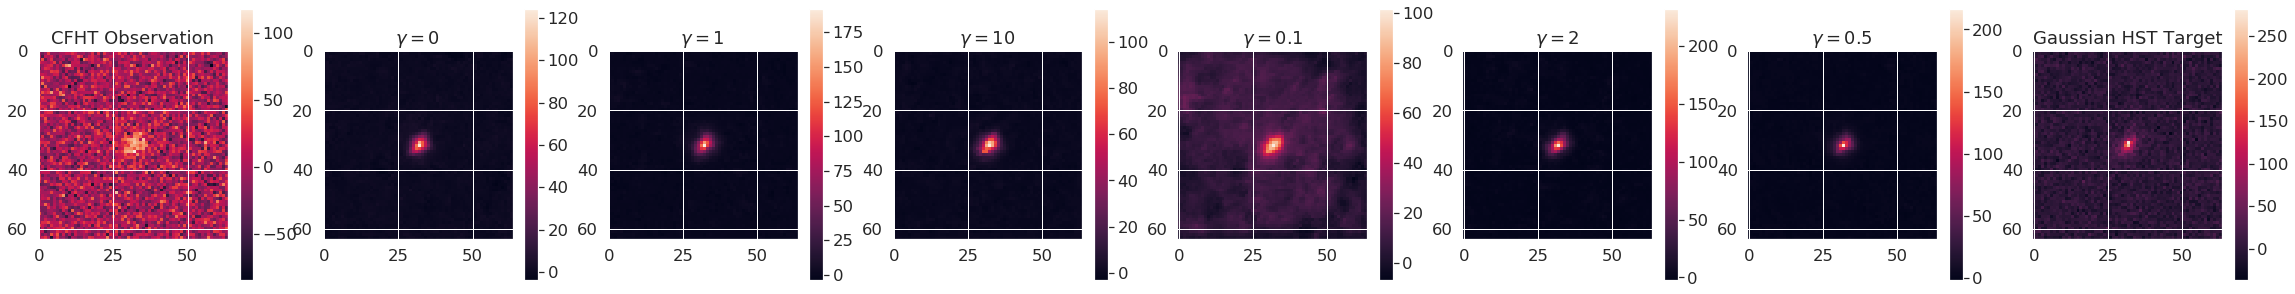

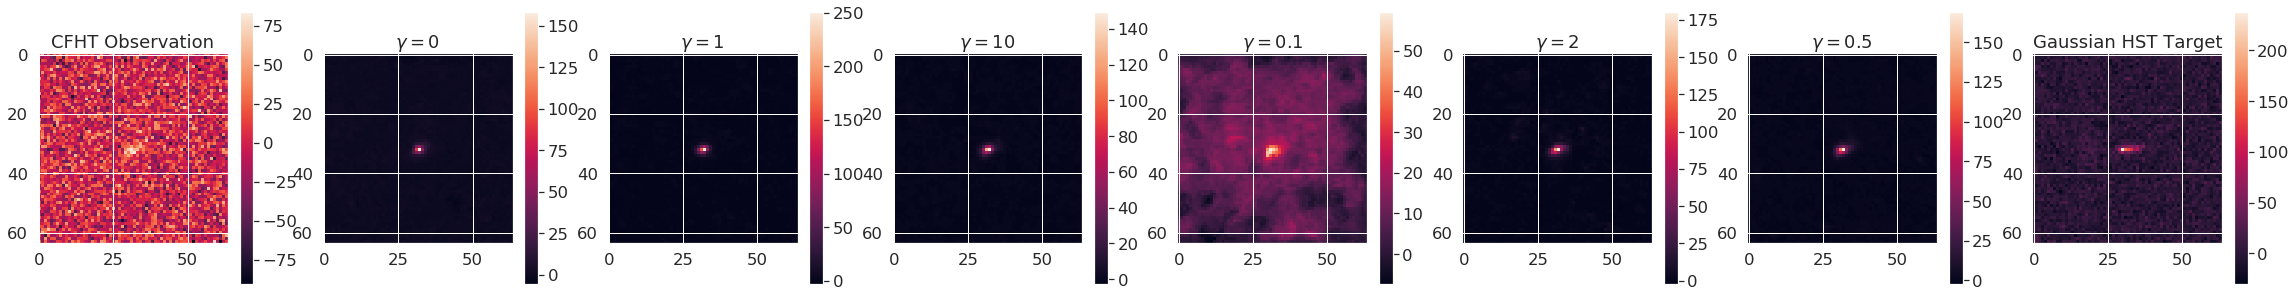

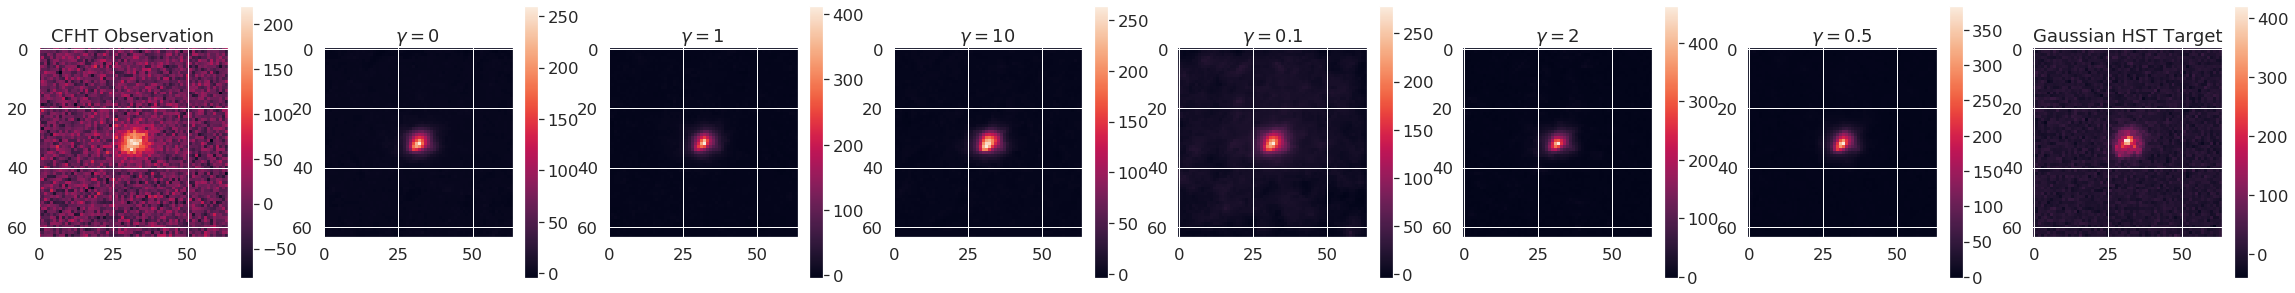

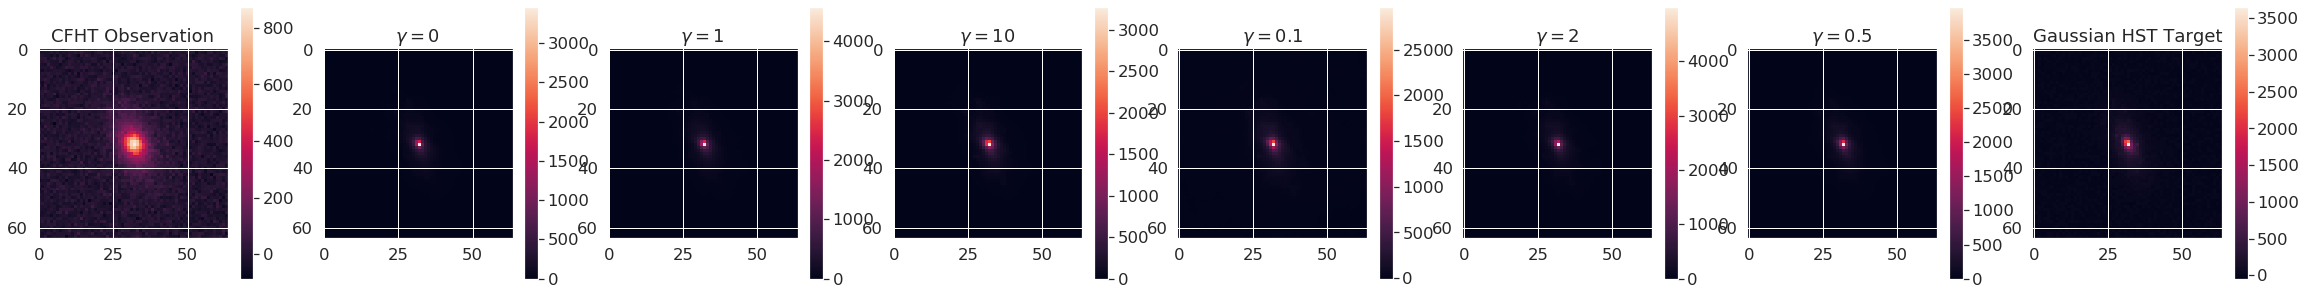

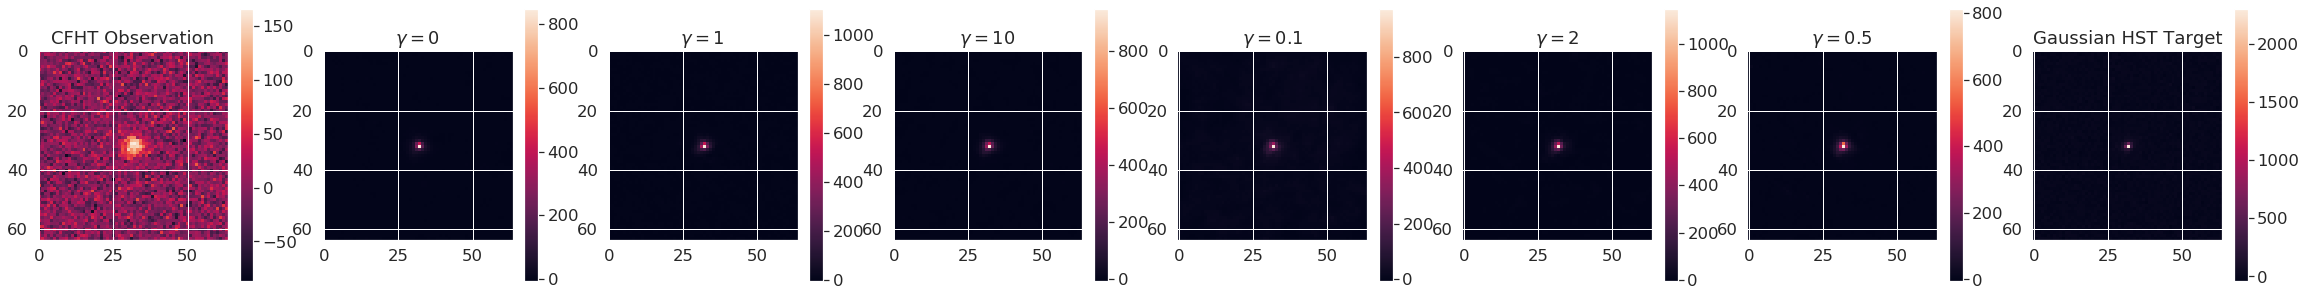

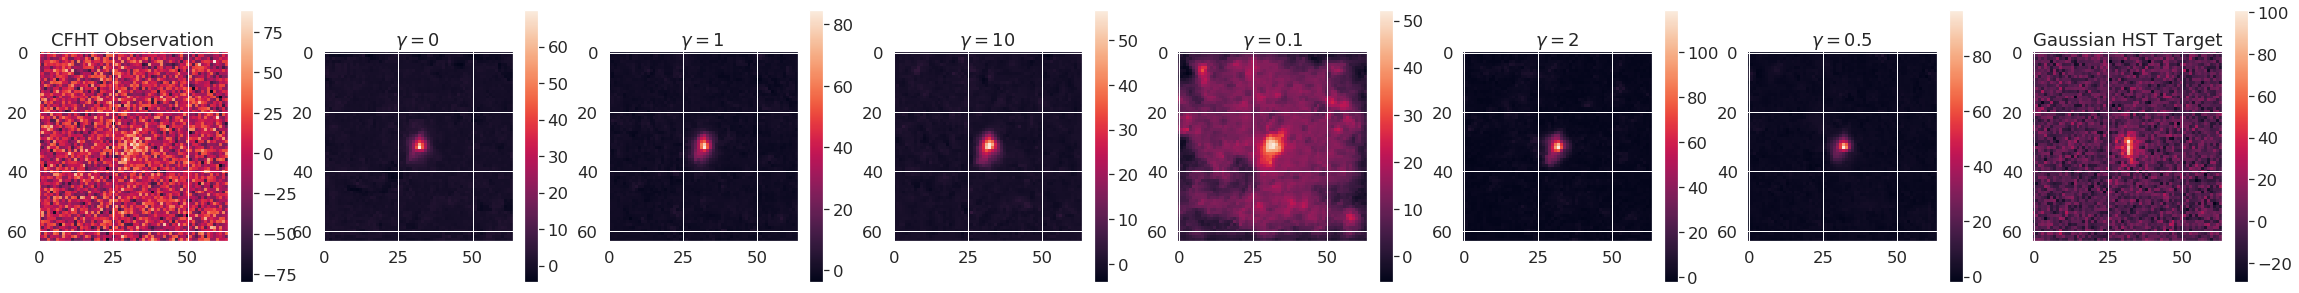

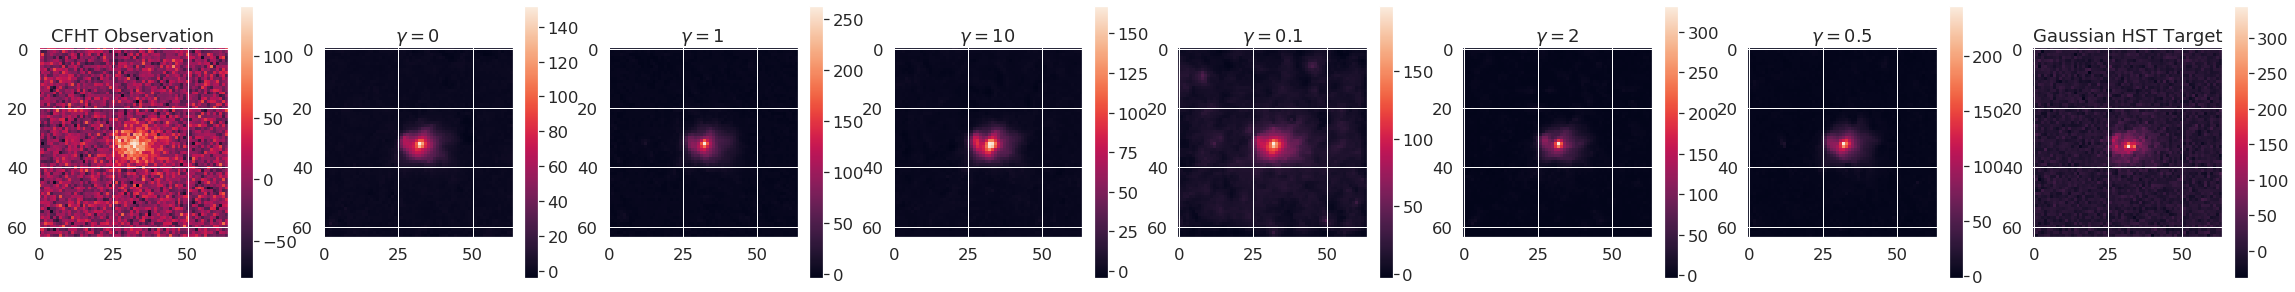

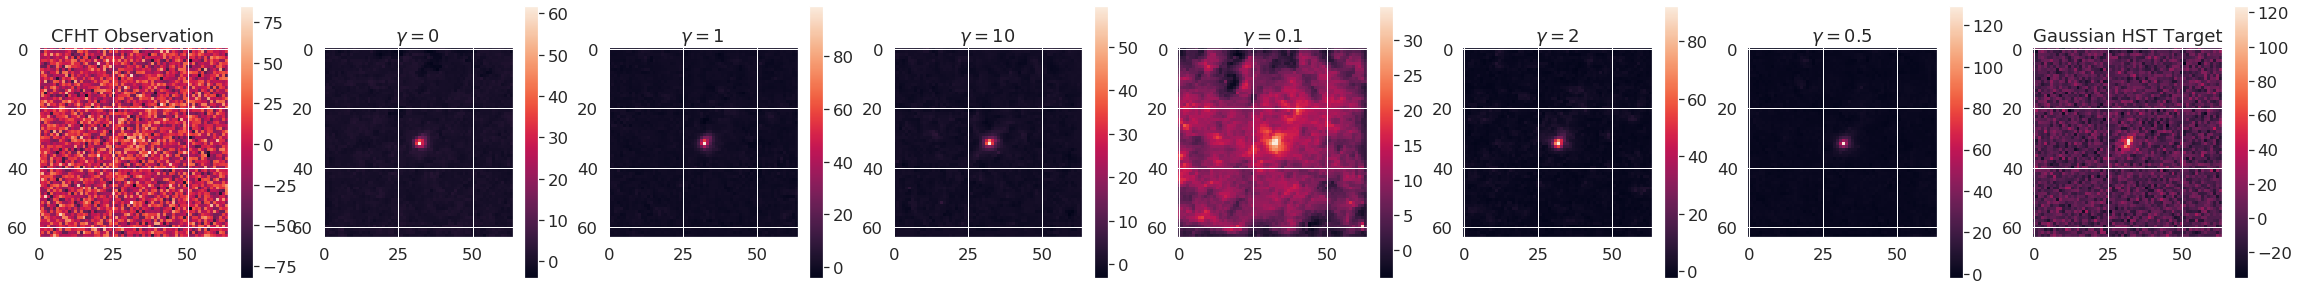

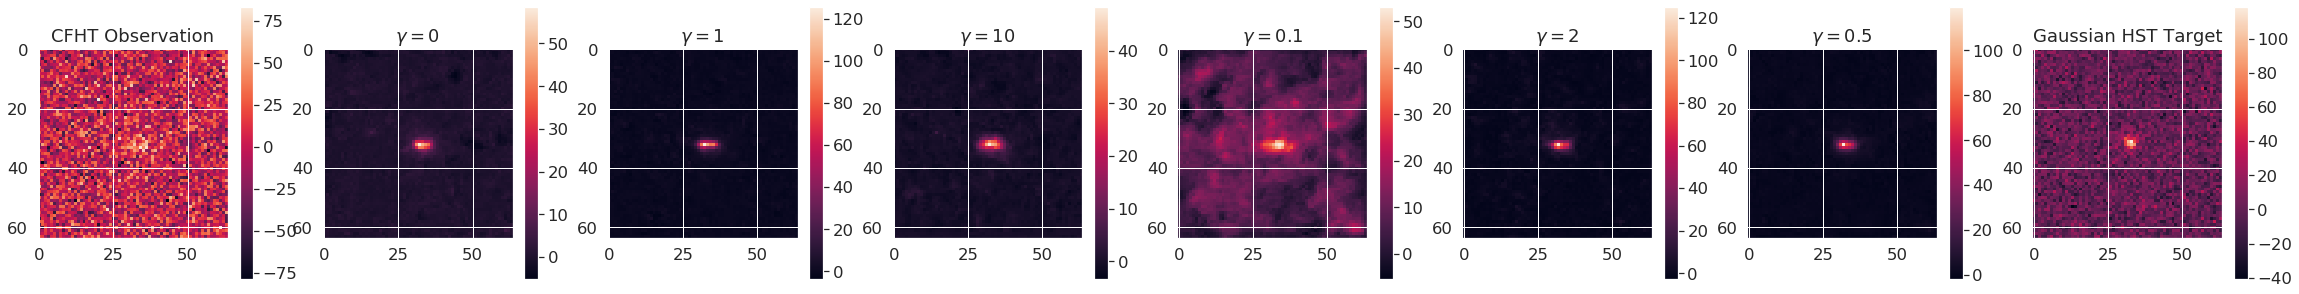

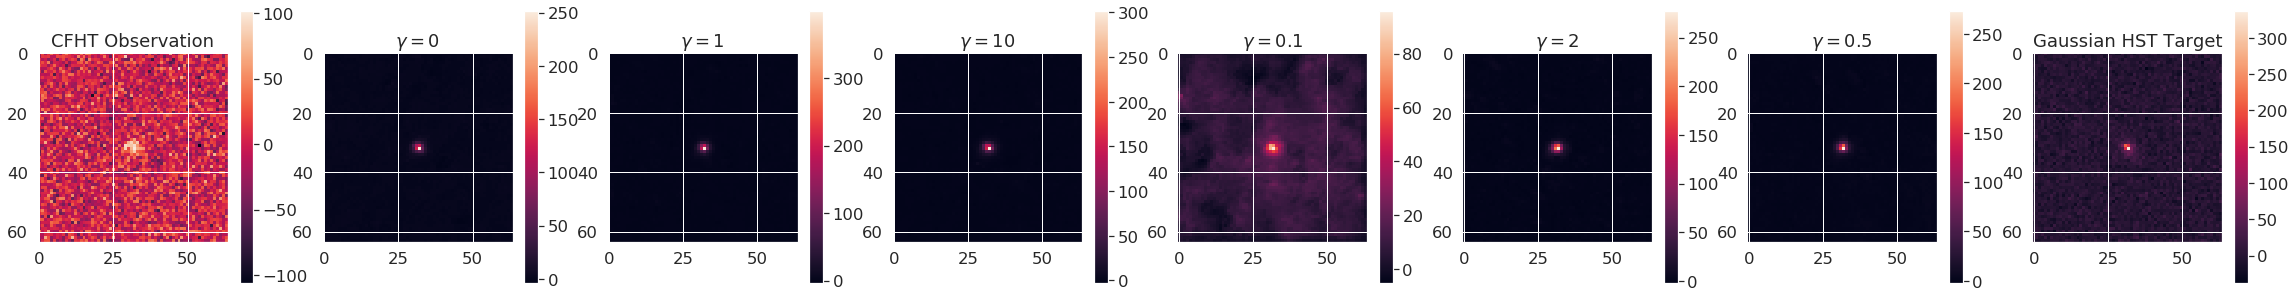

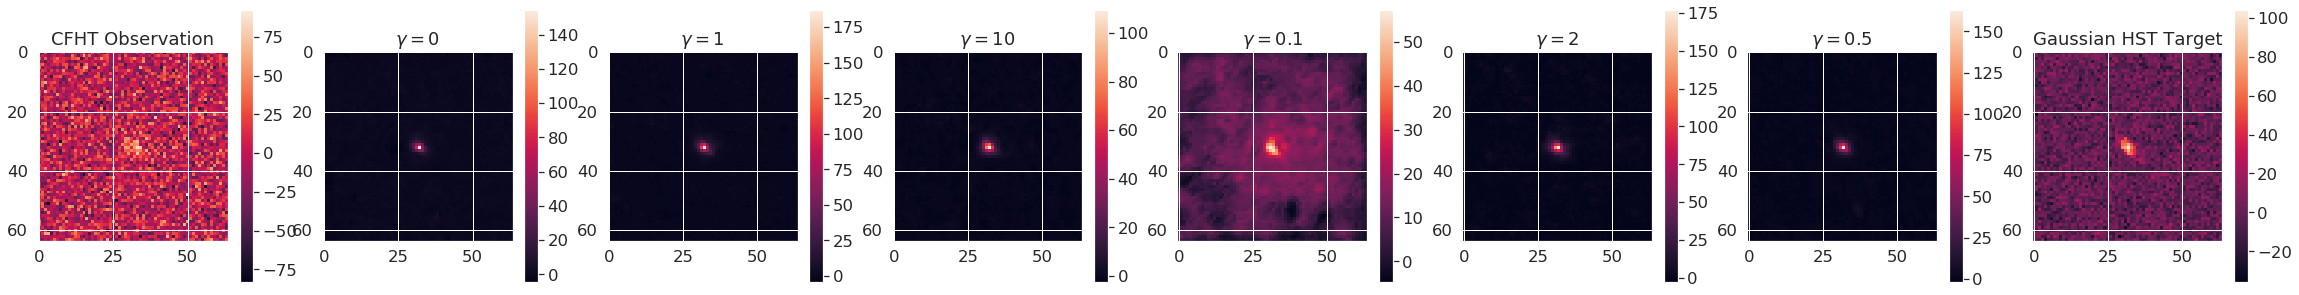

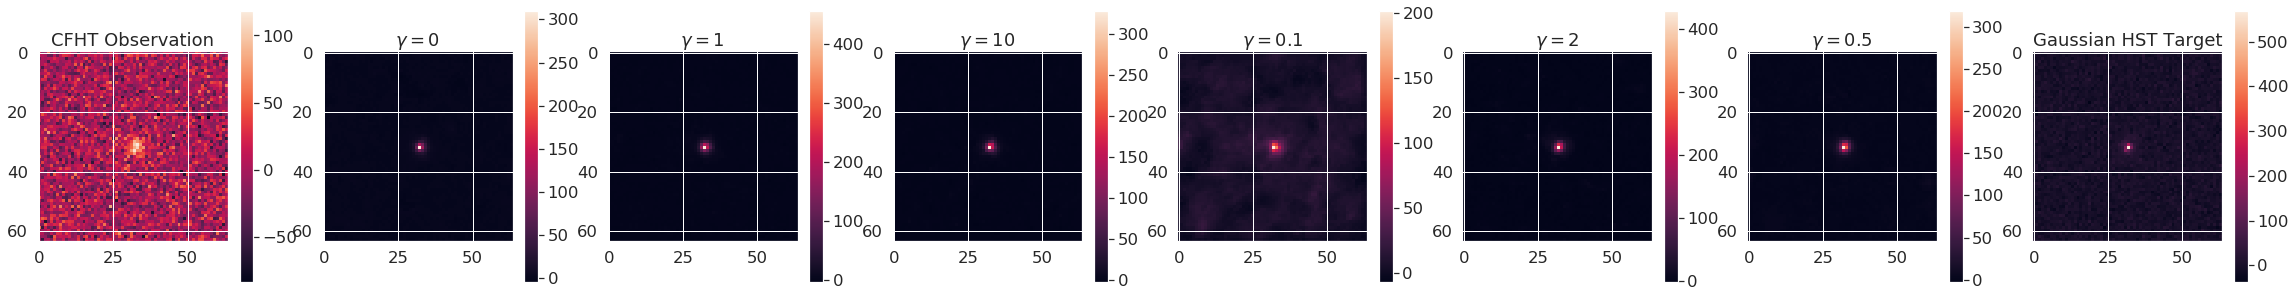

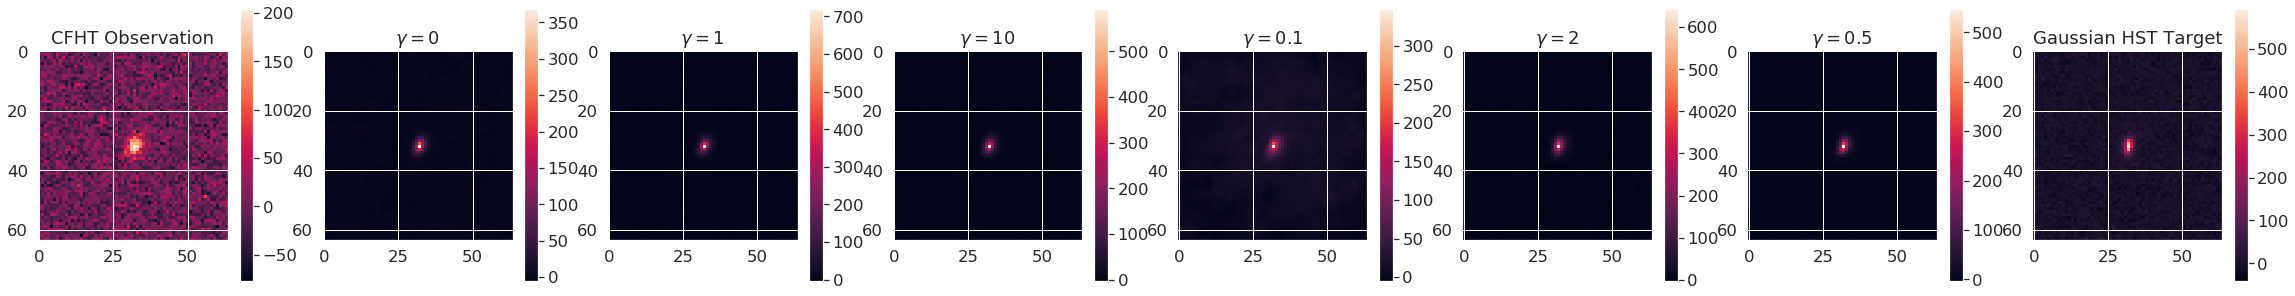

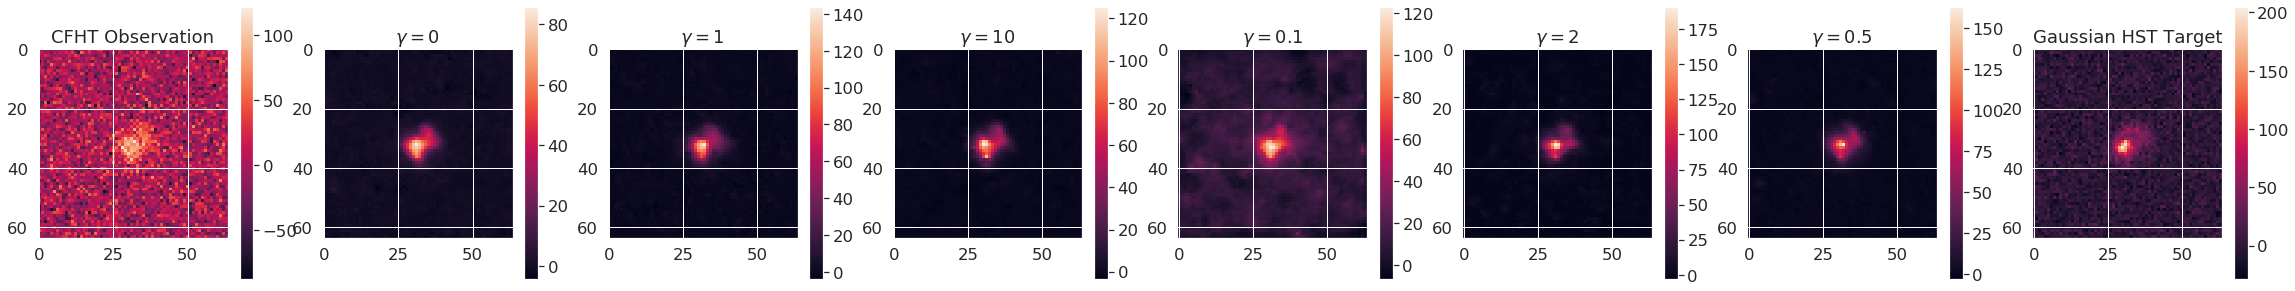

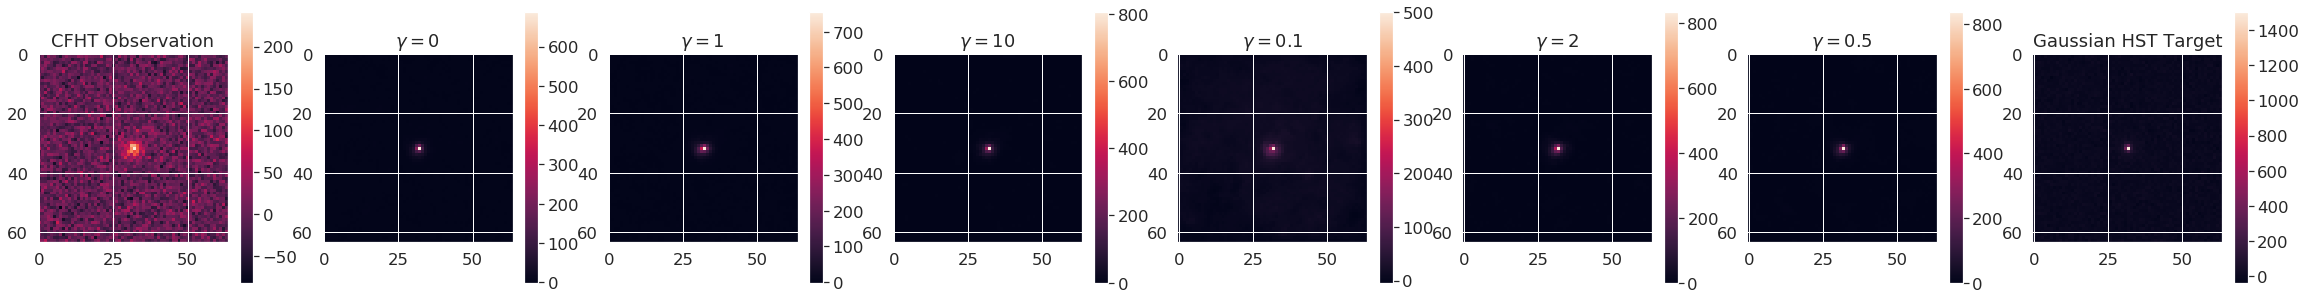

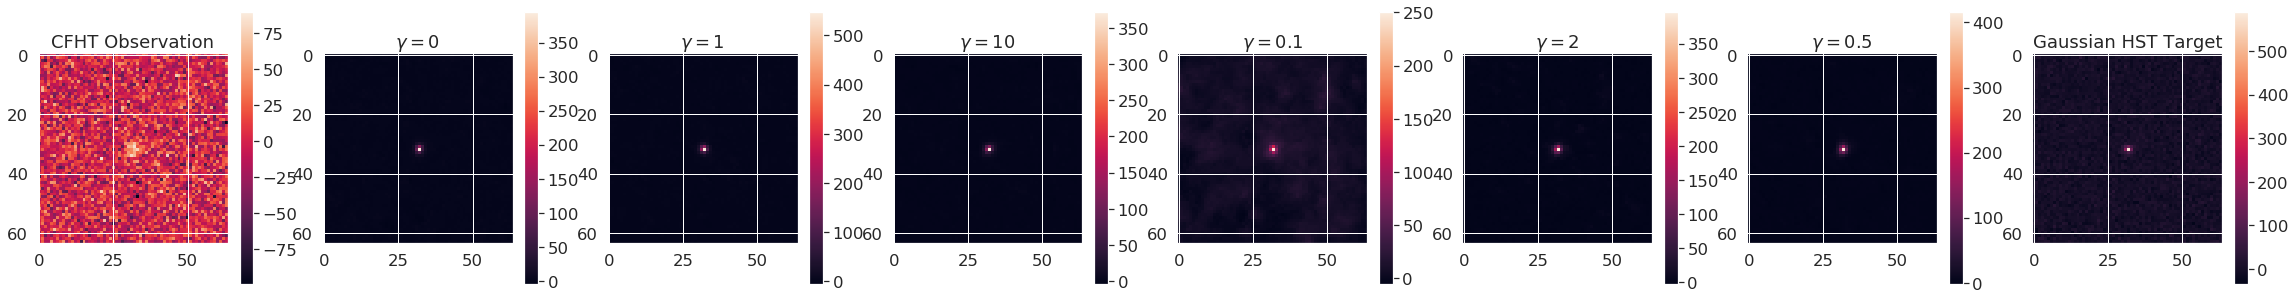

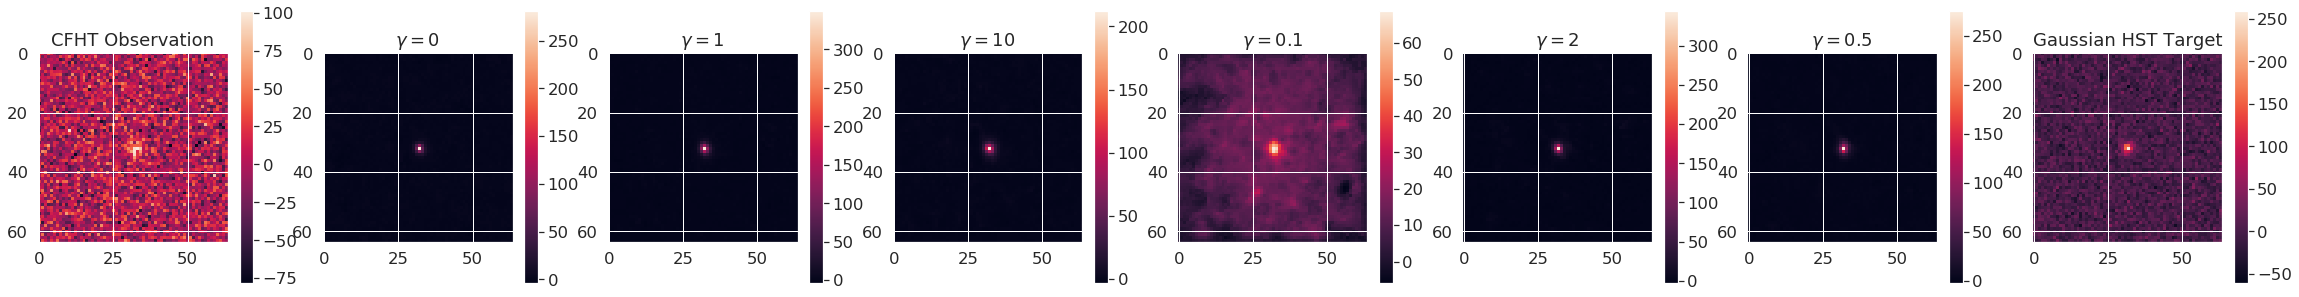

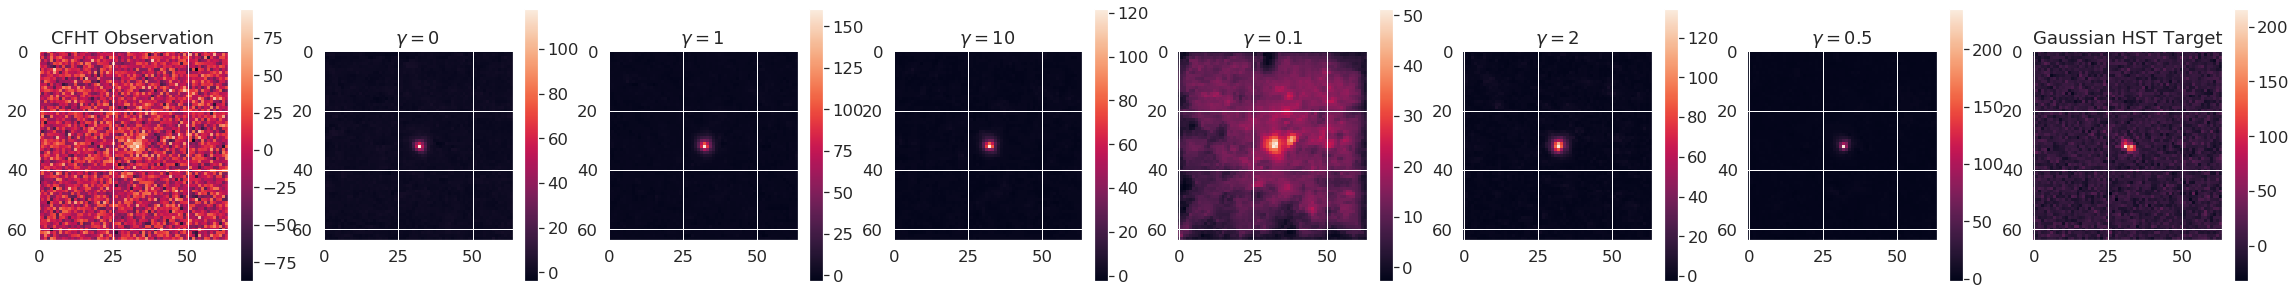

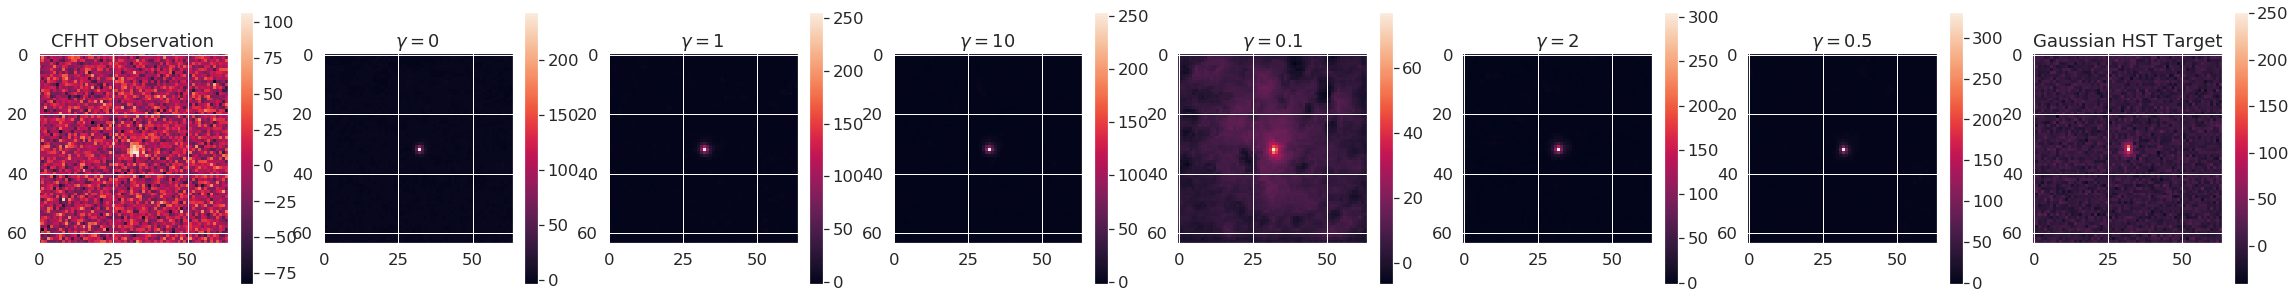

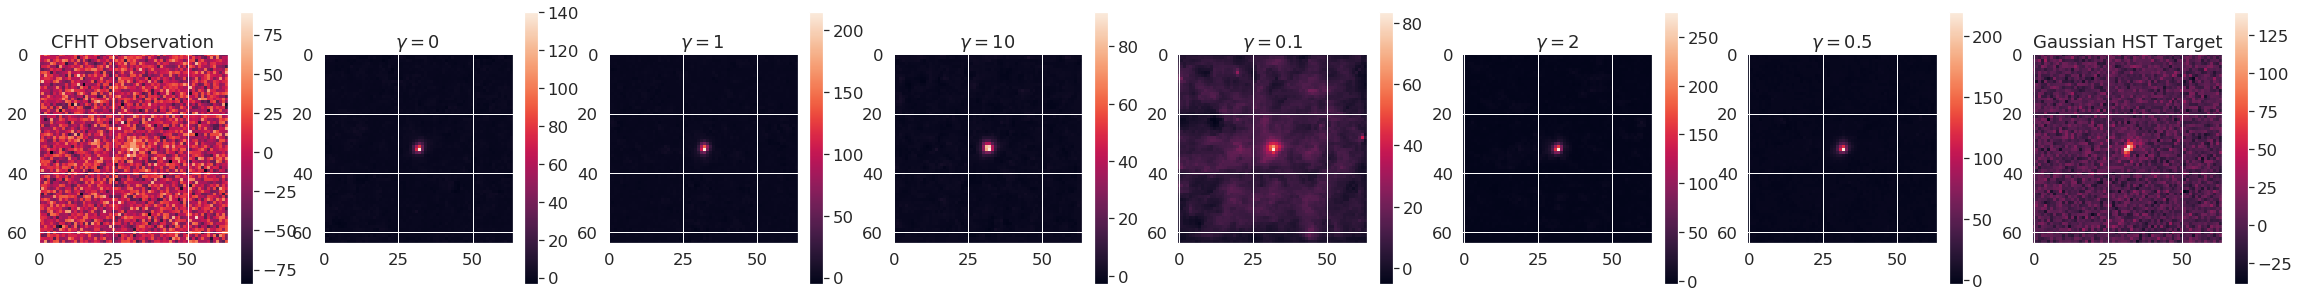

In [5]:
# set seaborn theme and style
sns.set_theme()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

for i in range(20):#n_batch):
    plt.figure(33,figsize=(40,5))
    plt.subplot(181)
    plt.imshow(batch['inputs'][i])
    plt.title('CFHT Observation')
    plt.colorbar()
    plt.subplot(182)
    plt.imshow(res_np[i])
    plt.title(r'$\gamma = 0$')
    plt.colorbar()
    plt.subplot(183)
    plt.imshow(res_g1_np[i])
    plt.title(r'$\gamma = 1$')
    plt.colorbar()
    plt.subplot(184)
    plt.imshow(res_g10_np[i])
    plt.title(r'$\gamma = 10$')
    plt.colorbar()
    plt.subplot(185)
    plt.imshow(res_g01_np[i])
    plt.title(r'$\gamma = 0.1$')
    plt.colorbar()
    plt.subplot(186)
    plt.imshow(res_g2_np[i])
    plt.title(r'$\gamma = 2$')
    plt.colorbar()
    plt.subplot(187)
    plt.imshow(res_g05_np[i])
    plt.title(r'$\gamma = 0.5$')
    plt.colorbar()
    plt.subplot(188)
    plt.imshow(batch['targets'][i])
    plt.title('Gaussian HST Target')
    plt.colorbar()
    plt.show()

## Processing and Analyzing Results

### Define Error Metrics

In [6]:
U = cl.makeUi(*batch['inputs_tikho'].shape[1:3])
im_size = 64
scale = 0.1

def estimate_ell(img):
    GX = np.array([cl.scal(img,U_i) for U_i in U])
    mu20 = 0.5*(GX[3]+GX[4])-GX[0]**2/GX[2]
    mu02 = 0.5*(GX[3]-GX[4])-GX[1]**2/GX[2]
    mu11 = GX[5]-GX[0]*GX[1]/GX[2]
    e1 = (mu20-mu02)/(mu20+mu02)
    e2 = 2*(mu11)/(mu20+mu02)
    e = np.array([e1,e2])
    return e

def EllipticalGaussian(e1, e2, sig, xc=im_size//2, yc=im_size//2, stamp_size=(im_size,im_size)):
    # compute centered grid
    ranges = np.array([np.arange(i) for i in stamp_size])
    x = np.outer(ranges[0] - xc, np.ones(stamp_size[1]))
    y = np.outer(np.ones(stamp_size[0]),ranges[1] - yc)
    # shift it to match centroid
    xx = (1-e1/2)*x - e2/2*y
    yy = (1+e1/2)*y - e2/2*x
    # compute elliptical gaussian
    return np.exp(-(xx ** 2 + yy ** 2) / (2 * sig ** 2))

def relative_mse(solution, ground_truth):
    relative_mse = ((solution-ground_truth)**2).mean()/ \
                         (ground_truth**2).mean()
    return relative_mse



def get_KSB_ell(image,psf):
    error_flag = True
    #create a galsim version of the data
    image_galsim = Image(image,scale=scale)
    psf_galsim = Image(psf,scale=scale)
    #estimate the moments of the observation image
    ell=galsim.hsm.EstimateShear(image_galsim
                                 ,psf_galsim,shear_est='KSB'
                                 ,guess_centroid=galsim.PositionD(im_size//2,im_size//2)
                                 ,strict=False)
    if ell.error_message != '':
        error_flag = False
    return ell#,error_flag

def get_KSB_g(images,psfs):
    g_list,error_flag_list=[],[]
    for image,psf in zip(images,psfs):
        error_flag = True
        #create a galsim version of the data
        image_galsim = galsim.Image(image,scale=scale)
        # CHECK ADAPTIVE MOMENTS
        psf_galsim = galsim.Image(psf,scale=scale)
        #estimate the moments of the observation image
        shape = galsim.hsm.EstimateShear(image_galsim
                                         ,psf_galsim,shear_est='KSB'
                                         ,guess_centroid=galsim.PositionD(im_size//2,im_size//2)
                                         ,strict=False)
        g = np.array([shape.corrected_g1, shape.corrected_g2])
#        g = np.array([shape.observed_shape.g1, shape.observed_shape.g2])
        if shape.error_message:# or np.linalg.norm(shape.corrected_g1+shape.corrected_g2*1j)>1:
            error_flag = False
        error_flag_list += [error_flag]
        g_list += [g]
    return np.array(g_list).T,np.array(error_flag_list)

def get_moments(images, bool_window=False):
    g_list,error_flag_list=[],[]
    if bool_window:
        window_list = []
        window_flag_list = []
    for image in images:
        error_flag = True
        #create a galsim version of the data
        image_galsim = galsim.Image(image,scale=scale)
        #estimate the moments of the observation image
        shape = galsim.hsm.FindAdaptiveMom(image_galsim
                                         ,guess_centroid=galsim.PositionD(im_size//2,im_size//2)
                                         ,strict=False)
        if bool_window:
            k_sigma = 3 #scale up the size of the Gaussian window to make it able to capture more useful signal
            window = EllipticalGaussian(-1.*shape.observed_shape.e1, shape.observed_shape.e2 #convention fix:
                                                                                             #e1 sign swap
                                 ,shape.moments_sigma*k_sigma # convention fix: swap x and y and origin at (0,0)
                                 ,shape.moments_centroid.y-1, shape.moments_centroid.x-1
                                 ,image.shape)
            window_flag = bool(shape.moments_status+1)
        g = np.array([shape.observed_shape.g1, shape.observed_shape.g2])
        if shape.error_message:# or np.linalg.norm(shape.corrected_g1+shape.corrected_g2*1j)>1:
            error_flag = False
        error_flag_list += [error_flag]
        g_list += [g]
        if bool_window:
            window_list += [window]
            window_flag_list += [window_flag]
    output = [np.array(g_list).T,np.array(error_flag_list)]
    if bool_window:
        output += [np.array([window_list])[0],np.array([window_flag_list])[0]]
    return output

def g_to_e(g1,g2):
    shear = galsim.Shear(g1=g1,g2=g2)
    ell = -shear.e1, shear.e2 #reverse the signe of e_1 to get our conventions
    return ell

def MSE(X1,X2,norm=False):
    #Computes the relative MSE
    temp = 1
    if norm:
        temp = np.mean(X2**2)
    return np.mean((X1-X2)**2)/temp

def MSE_obj(obj1,obj2,norm=False):
    return np.array([MSE(o1,o2,norm) for o1,o2 in zip(obj1,obj2)])

### Estimate Unwindowed Ellipticities, KSB shear and Adaptive Moments

In [7]:
ell_g0 = np.array([estimate_ell(gal) for gal in res_np]).T
ell_g1 = np.array([estimate_ell(gal) for gal in res_g1_np]).T
ell_g10 = np.array([estimate_ell(gal) for gal in res_g10_np]).T
ell_g01 = np.array([estimate_ell(gal) for gal in res_g01_np]).T
ell_g2 = np.array([estimate_ell(gal) for gal in res_g2_np]).T
ell_g05 = np.array([estimate_ell(gal) for gal in res_g05_np]).T
ell_hst = np.array([estimate_ell(gal) for gal in batch['targets']]).T

ksb_g0,_ = get_KSB_g(res_np,psf_tile_hst)
ksb_g1,_ = get_KSB_g(res_g1_np,psf_tile_hst)
ksb_g10,_ = get_KSB_g(res_g10_np,psf_tile_hst)
ksb_g01,_ = get_KSB_g(res_g01_np,psf_tile_hst)
ksb_g2,_ = get_KSB_g(res_g2_np,psf_tile_hst)
ksb_g05,_ = get_KSB_g(res_g05_np,psf_tile_hst)
ksb_hst,_ = get_KSB_g(batch['targets'],psf_tile_hst)

mom_g0,_ = get_moments(res_np)
mom_g1,_ = get_moments(res_g1_np)
mom_g10,_ = get_moments(res_g10_np)
mom_g01,_ = get_moments(res_g01_np)
mom_g2,_ = get_moments(res_g2_np)
mom_g05,_ = get_moments(res_g05_np)
mom_hst,_,windows, window_flags = get_moments(batch['targets'],bool_window=True)

### Estimate Moments and Absolute Pixel Errors

In [33]:
# compute pixel errors
mse_g0 = np.array([MSE_obj(true,est) for true,est in zip(batch['targets'], res_np)])
mse_g1 = np.array([MSE_obj(true,est) for true,est in zip(batch['targets'], res_g1_np)])
mse_g10 = np.array([MSE_obj(true,est) for true,est in zip(batch['targets'], res_g10_np)])
mse_g01 = np.array([MSE_obj(true,est) for true,est in zip(batch['targets'], res_g01_np)])
mse_g2 = np.array([MSE_obj(true,est) for true,est in zip(batch['targets'], res_g2_np)])
mse_g05 = np.array([MSE_obj(true,est) for true,est in zip(batch['targets'], res_g05_np)])

# # compute relative pixel errors
# mse_g0 = np.array([relative_mse(true,est) for true,est in zip(batch['targets'], res_np)])
# mse_g1 = np.array([relative_mse(true,est) for true,est in zip(batch['targets'], res_g1_np)])
# mse_g10 = np.array([relative_mse(true,est) for true,est in zip(batch['targets'], res_g10_np)])
# mse_g01 = np.array([relative_mse(true,est) for true,est in zip(batch['targets'], res_g01_np)])
# mse_g2 = np.array([relative_mse(true,est) for true,est in zip(batch['targets'], res_g2_np)])
# mse_g05 = np.array([relative_mse(true,est) for true,est in zip(batch['targets'], res_g05_np)])

# # compute winodwed pixel errors
# mse_g0_w = np.array([MSE_obj(true*w,est*w) for true,est,w in zip(batch['targets'], res_np,windows)])
# mse_g1_w = np.array([MSE_obj(true*w,est*w) for true,est,w in zip(batch['targets'], res_g1_np,windows)])
# mse_g10_w = np.array([MSE_obj(true*w,est*w) for true,est,w in zip(batch['targets'], res_g10_np,windows)])
# mse_g01_w = np.array([MSE_obj(true*w,est*w) for true,est,w in zip(batch['targets'], res_g01_np,windows)])
# mse_g2_w = np.array([MSE_obj(true*w,est*w) for true,est,w in zip(batch['targets'], res_g2_np,windows)])
# mse_g05_w = np.array([MSE_obj(true*w,est*w) for true,est,w in zip(batch['targets'], res_g05_np,windows)])

# compute winodwed pixel relative errors
mse_g0_w = np.array([relative_mse(true*w,est*w) for true,est,w in zip(batch['targets'], res_np,windows)])
mse_g1_w = np.array([relative_mse(true*w,est*w) for true,est,w in zip(batch['targets'], res_g1_np,windows)])
mse_g10_w = np.array([relative_mse(true*w,est*w) for true,est,w in zip(batch['targets'], res_g10_np,windows)])
mse_g01_w = np.array([relative_mse(true*w,est*w) for true,est,w in zip(batch['targets'], res_g01_np,windows)])
mse_g2_w = np.array([relative_mse(true*w,est*w) for true,est,w in zip(batch['targets'], res_g2_np,windows)])
mse_g05_w = np.array([relative_mse(true*w,est*w) for true,est,w in zip(batch['targets'], res_g05_np,windows)])

# compute adapative moments errors
mom_err_g0 = mom_g0-mom_hst
mom_err_g1 = mom_g1-mom_hst
mom_err_g10 = mom_g10-mom_hst
mom_err_g01 = mom_g01-mom_hst
mom_err_g2 = mom_g2-mom_hst
mom_err_g05 = mom_g05-mom_hst

# # compute adapative moments relative errors
# mom_err_g0 = (mom_g0-mom_hst)/mom_hst
# mom_err_g1 = (mom_g1-mom_hst)/mom_hst
# mom_err_g10 = (mom_g10-mom_hst)/mom_hst
# mom_err_g01 = (mom_g01-mom_hst)/mom_hst
# mom_err_g2 = (mom_g2-mom_hst)/mom_hst
# mom_err_g05 = (mom_g05-mom_hst)/mom_hst

#compute ellipticity errors
ell_err_g0 = ell_g0 - ell_hst
ell_err_g1 = ell_g1 - ell_hst
ell_err_g10 = ell_g10 - ell_hst
ell_err_g01 = ell_g01 - ell_hst
ell_err_g2 = ell_g2 - ell_hst
ell_err_g05 = ell_g05 - ell_hst

# #compute ellipticity relative errors
# ell_err_g0 = (ell_g0 - ell_hst)/ell_hst
# ell_err_g1 = (ell_g1 - ell_hst)/ell_hst
# ell_err_g10 = (ell_g10 - ell_hst)/ell_hst
# ell_err_g01 = (ell_g01 - ell_hst)/ell_hst
# ell_err_g2 = (ell_g2 - ell_hst)/ell_hst
# ell_err_g05 = (ell_g05 - ell_hst)/ell_hst

### Compute Errors per Bin

In [34]:
label_g0 = r'$\gamma = 0$'
label_g1 = r'$\gamma = 1$'
label_g10 = r'$\gamma = 10$'
label_g01 = r'$\gamma = 0.1$'
label_g2 = r'$\gamma = 2$'
label_g05 = r'$\gamma = 0.5$'

color_g0 = 'silver'
color_g01 = 'lightsteelblue'
color_g05 = 'cornflowerblue'
color_g1 = 'blue'
color_g2 = 'navy'
color_g10 = 'black'

## Warning: Window Estimation Failures Are Filtered

As shown in the cell below, one third of the window estimation fail. As a first approach we tackle this problem by removing the failures from the analyzed data. 

In [35]:
print('Proportion of failed window estimations: {}'.format(1-window_flags.sum()/window_flags.size))

Proportion of failed window estimations: 0.34342447916666663


### Computing Errors

In [36]:
# Filter the data
original_indices = np.arange(window_flags.size)[window_flags]

# compute pixel errors
mse_g0_win = mse_g0[window_flags]
mse_g1_win = mse_g1[window_flags]
mse_g10_win = mse_g10[window_flags]
mse_g01_win = mse_g01[window_flags]
mse_g2_win = mse_g2[window_flags]
mse_g05_win = mse_g05[window_flags]

# compute winodwed relative pixel errors
mse_g0_win_w = mse_g0_w[window_flags]
mse_g1_win_w = mse_g1_w[window_flags]
mse_g10_win_w = mse_g10_w[window_flags]
mse_g01_win_w = mse_g01_w[window_flags]
mse_g2_win_w = mse_g2_w[window_flags]
mse_g05_win_w = mse_g05_w[window_flags]

# compute adapative moments errors
mom_err_g0_win = mom_err_g0[:,window_flags]
mom_err_g1_win = mom_err_g1[:,window_flags]
mom_err_g10_win = mom_err_g10[:,window_flags]
mom_err_g01_win = mom_err_g01[:,window_flags]
mom_err_g2_win = mom_err_g2[:,window_flags]
mom_err_g05_win = mom_err_g05[:,window_flags]

# compute ellipticity errors
ell_err_g0_win = ell_err_g0[:,window_flags]
ell_err_g1_win = ell_err_g1[:,window_flags]
ell_err_g10_win = ell_err_g10[:,window_flags]
ell_err_g01_win = ell_err_g01[:,window_flags]
ell_err_g2_win = ell_err_g2[:,window_flags]
ell_err_g05_win = ell_err_g05[:,window_flags]


# MAKING MAG BINS
# Binning parameters
n_bins = 4
lower_bound = np.min(batch['mag_auto'][window_flags])
mag_quantiles = []
mag_means =[]

# computing mean and standard deviation of adapative moments error per binned magnitude

mom_mean_g0 = []
mom_mean_g1 = []
mom_mean_g10 = []
mom_mean_g01 = []
mom_mean_g2 = []
mom_mean_g05 = []

mom_std_g0 = []
mom_std_g1 = []
mom_std_g10 = []
mom_std_g01 = []
mom_std_g2 = []
mom_std_g05 = []

# computing mean and standard deviation of ellipticity error per binned magnitude

ell_mean_g0 = []
ell_mean_g1 = []
ell_mean_g10 = []
ell_mean_g01 = []
ell_mean_g2 = []
ell_mean_g05 = []

ell_std_g0 = []
ell_std_g1 = []
ell_std_g10 = []
ell_std_g01 = []
ell_std_g2 = []
ell_std_g05 = []

# computing mean and standard deviation of relative mse error per binned magnitude

mse_mean_g0 = []
mse_mean_g1 = []
mse_mean_g10 = []
mse_mean_g01 = []
mse_mean_g2 = []
mse_mean_g05 = []

mse_std_g0 = []
mse_std_g1 = []
mse_std_g10 = []
mse_std_g01 = []
mse_std_g2 = []
mse_std_g05 = []

mse_mean_g0_w = []
mse_mean_g1_w = []
mse_mean_g10_w = []
mse_mean_g01_w = []
mse_mean_g2_w = []
mse_mean_g05_w = []

mse_std_g0_w = []
mse_std_g1_w = []
mse_std_g10_w = []
mse_std_g01_w = []
mse_std_g2_w = []
mse_std_g05_w = []

for i in range(n_bins-1):
    q = np.quantile(batch['mag_auto'][window_flags],(i+1)/n_bins)
    ind = np.logical_and(lower_bound<=batch['mag_auto'][window_flags],batch['mag_auto'][window_flags]<q)
    mag_quantiles += [q]
    mag_means += [np.mean(batch['mag_auto'][window_flags][ind])]
    lower_bound = q
    mom_mean_g0 += [np.mean(np.abs(mom_err_g0_win[:,ind]),axis=1)]
    mom_mean_g1 += [np.mean(np.abs(mom_err_g1_win[:,ind]),axis=1)]
    mom_mean_g10 += [np.mean(np.abs(mom_err_g10_win[:,ind]),axis=1)]
    mom_mean_g01 += [np.mean(np.abs(mom_err_g01_win[:,ind]),axis=1)]
    mom_mean_g2 += [np.mean(np.abs(mom_err_g2_win[:,ind]),axis=1)]
    mom_mean_g05 += [np.mean(np.abs(mom_err_g05_win[:,ind]),axis=1)]

    mom_std_g0 += [np.std(np.abs(mom_err_g0_win[:,ind]),axis=1)]
    mom_std_g1 += [np.std(np.abs(mom_err_g1_win[:,ind]),axis=1)]
    mom_std_g10 += [np.std(np.abs(mom_err_g10_win[:,ind]),axis=1)]
    mom_std_g01 += [np.std(np.abs(mom_err_g01_win[:,ind]),axis=1)]
    mom_std_g2 += [np.std(np.abs(mom_err_g2_win[:,ind]),axis=1)]
    mom_std_g05 += [np.std(np.abs(mom_err_g05_win[:,ind]),axis=1)]
    
    ell_mean_g0 += [np.mean(np.abs(ell_err_g0_win[:,ind]),axis=1)]
    ell_mean_g1 += [np.mean(np.abs(ell_err_g1_win[:,ind]),axis=1)]
    ell_mean_g10 += [np.mean(np.abs(ell_err_g10_win[:,ind]),axis=1)]
    ell_mean_g01 += [np.mean(np.abs(ell_err_g01_win[:,ind]),axis=1)]
    ell_mean_g2 += [np.mean(np.abs(ell_err_g2_win[:,ind]),axis=1)]
    ell_mean_g05 += [np.mean(np.abs(ell_err_g05_win[:,ind]),axis=1)]

    ell_std_g0 += [np.std(np.abs(ell_err_g0_win[:,ind]),axis=1)]
    ell_std_g1 += [np.std(np.abs(ell_err_g1_win[:,ind]),axis=1)]
    ell_std_g10 += [np.std(np.abs(ell_err_g10_win[:,ind]),axis=1)]
    ell_std_g01 += [np.std(np.abs(ell_err_g01_win[:,ind]),axis=1)]
    ell_std_g2 += [np.std(np.abs(ell_err_g2_win[:,ind]),axis=1)]
    ell_std_g05 += [np.std(np.abs(ell_err_g05_win[:,ind]),axis=1)]
    
    mse_mean_g0 += [np.mean(mse_g0_win[ind])]
    mse_mean_g1 += [np.mean(mse_g1_win[ind])]
    mse_mean_g10 += [np.mean(mse_g10_win[ind])]
    mse_mean_g01 += [np.mean(mse_g01_win[ind])]
    mse_mean_g2 += [np.mean(mse_g2_win[ind])]
    mse_mean_g05 += [np.mean(mse_g05_win[ind])]

    mse_std_g0 += [np.std(mse_g0_win[ind])]
    mse_std_g1 += [np.std(mse_g1_win[ind])]
    mse_std_g10 += [np.std(mse_g10_win[ind])]
    mse_std_g01 += [np.std(mse_g01_win[ind])]
    mse_std_g2 += [np.std(mse_g2_win[ind])]
    mse_std_g05 += [np.std(mse_g05_win[ind])]
    
    mse_mean_g0_w += [np.mean(mse_g0_win_w[ind])]
    mse_mean_g1_w += [np.mean(mse_g1_win_w[ind])]
    mse_mean_g10_w += [np.mean(mse_g10_win_w[ind])]
    mse_mean_g01_w += [np.mean(mse_g01_win_w[ind])]
    mse_mean_g2_w += [np.mean(mse_g2_win_w[ind])]
    mse_mean_g05_w += [np.mean(mse_g05_win_w[ind])]

    mse_std_g0_w += [np.std(mse_g0_win_w[ind])]
    mse_std_g1_w += [np.std(mse_g1_win_w[ind])]
    mse_std_g10_w += [np.std(mse_g10_win_w[ind])]
    mse_std_g01_w += [np.std(mse_g01_win_w[ind])]
    mse_std_g2_w += [np.std(mse_g2_win_w[ind])]
    mse_std_g05_w += [np.std(mse_g05_win_w[ind])]
    
# LAST BIN BEGIN
ind = lower_bound<=batch['mag_auto'][window_flags]
mom_mean_g0 += [np.mean(np.abs(mom_err_g0_win[:,ind]),axis=1)]
mom_mean_g1 += [np.mean(np.abs(mom_err_g1_win[:,ind]),axis=1)]
mom_mean_g10 += [np.mean(np.abs(mom_err_g10_win[:,ind]),axis=1)]
mom_mean_g01 += [np.mean(np.abs(mom_err_g01_win[:,ind]),axis=1)]
mom_mean_g2 += [np.mean(np.abs(mom_err_g2_win[:,ind]),axis=1)]
mom_mean_g05 += [np.mean(np.abs(mom_err_g05_win[:,ind]),axis=1)]

mom_std_g0 += [np.std(np.abs(mom_err_g0_win[:,ind]),axis=1)]
mom_std_g1 += [np.std(np.abs(mom_err_g1_win[:,ind]),axis=1)]
mom_std_g10 += [np.std(np.abs(mom_err_g10_win[:,ind]),axis=1)]
mom_std_g01 += [np.std(np.abs(mom_err_g01_win[:,ind]),axis=1)]
mom_std_g2 += [np.std(np.abs(mom_err_g2_win[:,ind]),axis=1)]
mom_std_g05 += [np.std(np.abs(mom_err_g05_win[:,ind]),axis=1)]

ell_mean_g0 += [np.mean(np.abs(ell_err_g0_win[:,ind]),axis=1)]
ell_mean_g1 += [np.mean(np.abs(ell_err_g1_win[:,ind]),axis=1)]
ell_mean_g10 += [np.mean(np.abs(ell_err_g10_win[:,ind]),axis=1)]
ell_mean_g01 += [np.mean(np.abs(ell_err_g01_win[:,ind]),axis=1)]
ell_mean_g2 += [np.mean(np.abs(ell_err_g2_win[:,ind]),axis=1)]
ell_mean_g05 += [np.mean(np.abs(ell_err_g05_win[:,ind]),axis=1)]

ell_std_g0 += [np.std(np.abs(ell_err_g0_win[:,ind]),axis=1)]
ell_std_g1 += [np.std(np.abs(ell_err_g1_win[:,ind]),axis=1)]
ell_std_g10 += [np.std(np.abs(ell_err_g10_win[:,ind]),axis=1)]
ell_std_g01 += [np.std(np.abs(ell_err_g01_win[:,ind]),axis=1)]
ell_std_g2 += [np.std(np.abs(ell_err_g2_win[:,ind]),axis=1)]
ell_std_g05 += [np.std(np.abs(ell_err_g05_win[:,ind]),axis=1)]

mse_mean_g0 += [np.mean(mse_g0_win[ind])]
mse_mean_g1 += [np.mean(mse_g1_win[ind])]
mse_mean_g10 += [np.mean(mse_g10_win[ind])]
mse_mean_g01 += [np.mean(mse_g01_win[ind])]
mse_mean_g2 += [np.mean(mse_g2_win[ind])]
mse_mean_g05 += [np.mean(mse_g05_win[ind])]

mse_std_g0 += [np.std(mse_g0_win[ind])]
mse_std_g1 += [np.std(mse_g1_win[ind])]
mse_std_g10 += [np.std(mse_g10_win[ind])]
mse_std_g01 += [np.std(mse_g01_win[ind])]
mse_std_g2 += [np.std(mse_g2_win[ind])]
mse_std_g05 += [np.std(mse_g05_win[ind])]

mse_mean_g0_w += [np.mean(mse_g0_win_w[ind])]
mse_mean_g1_w += [np.mean(mse_g1_win_w[ind])]
mse_mean_g10_w += [np.mean(mse_g10_win_w[ind])]
mse_mean_g01_w += [np.mean(mse_g01_win_w[ind])]
mse_mean_g2_w += [np.mean(mse_g2_win_w[ind])]
mse_mean_g05_w += [np.mean(mse_g05_win_w[ind])]

mse_std_g0_w += [np.std(mse_g0_win_w[ind])]
mse_std_g1_w += [np.std(mse_g1_win_w[ind])]
mse_std_g10_w += [np.std(mse_g10_win_w[ind])]
mse_std_g01_w += [np.std(mse_g01_win_w[ind])]
mse_std_g2_w += [np.std(mse_g2_win_w[ind])]
mse_std_g05_w += [np.std(mse_g05_win_w[ind])]

# LAST BIN END
    
# Convert to numpy array with shape (2, n_bins)

mom_mean_g0 = np.array(mom_mean_g0).T
mom_mean_g1 = np.array(mom_mean_g1).T
mom_mean_g10 = np.array(mom_mean_g10).T
mom_mean_g01 = np.array(mom_mean_g01).T
mom_mean_g2 = np.array(mom_mean_g2).T
mom_mean_g05 = np.array(mom_mean_g05).T

mom_std_g0 = np.array(mom_std_g0).T
mom_std_g1 = np.array(mom_std_g1).T
mom_std_g10 = np.array(mom_std_g10).T
mom_std_g01 = np.array(mom_std_g01).T
mom_std_g2 = np.array(mom_std_g2).T
mom_std_g05 = np.array(mom_std_g05).T

ell_mean_g0 = np.array(ell_mean_g0).T
ell_mean_g1 = np.array(ell_mean_g1).T
ell_mean_g10 = np.array(ell_mean_g10).T
ell_mean_g01 = np.array(ell_mean_g01).T
ell_mean_g2 = np.array(ell_mean_g2).T
ell_mean_g05 = np.array(ell_mean_g05).T

ell_std_g0 = np.array(ell_std_g0).T
ell_std_g1 = np.array(ell_std_g1).T
ell_std_g10 = np.array(ell_std_g10).T
ell_std_g01 = np.array(ell_std_g01).T
ell_std_g2 = np.array(ell_std_g2).T
ell_std_g05 = np.array(ell_std_g05).T

mse_mean_g0 = np.array(mse_mean_g0).T
mse_mean_g1 = np.array(mse_mean_g1).T
mse_mean_g10 = np.array(mse_mean_g10).T
mse_mean_g01 = np.array(mse_mean_g01).T
mse_mean_g2 = np.array(mse_mean_g2).T
mse_mean_g05 = np.array(mse_mean_g05).T

mse_std_g0 = np.array(mse_std_g0).T
mse_std_g1 = np.array(mse_std_g1).T
mse_std_g10 = np.array(mse_std_g10).T
mse_std_g01 = np.array(mse_std_g01).T
mse_std_g2 = np.array(mse_std_g2).T
mse_std_g05 = np.array(mse_std_g05).T

mse_mean_g0_w = np.array(mse_mean_g0_w).T
mse_mean_g1_w = np.array(mse_mean_g1_w).T
mse_mean_g10_w = np.array(mse_mean_g10_w).T
mse_mean_g01_w = np.array(mse_mean_g01_w).T
mse_mean_g2_w = np.array(mse_mean_g2_w).T
mse_mean_g05_w = np.array(mse_mean_g05_w).T

mse_std_g0_w = np.array(mse_std_g0_w).T
mse_std_g1_w = np.array(mse_std_g1_w).T
mse_std_g10_w = np.array(mse_std_g10_w).T
mse_std_g01_w = np.array(mse_std_g01_w).T
mse_std_g2_w = np.array(mse_std_g2_w).T
mse_std_g05_w = np.array(mse_std_g05_w).T

In [37]:
# BEGIN BINNING
# Partition galaxies into bins of equal size
# Initialize lower bound
lower_bound = np.min(batch['mag_auto'][window_flags])
gal_sum = 0
bins = []

sqrt_num_gal = [] # conversion factor of standard deviation to mean error standard deviation

for i in range(n_bins-1):
    # compute quantile that is used as an upper bound
    q = np.quantile(batch['mag_auto'][window_flags],(i+1)/n_bins)
    # retrieve galaxy indices which magnitude are between the bounds
    cond = np.logical_and(lower_bound<=batch['mag_auto'][window_flags],batch['mag_auto'][window_flags]<q)
    # retrieve corresponding objects
    mag_q = batch['mag_auto'][window_flags][cond]
    print(i+1, q, np.mean(mag_q))
    bins += [np.mean(mag_q)]
    # compute the square root of the bin size
    sqrt_num_gal += [np.sqrt(np.sum(cond))]
    # update lower bound
    lower_bound = q
# retrieve last bin indices
cond = lower_bound<=batch['mag_auto'][window_flags]
# retrieve corresponding objects
mag_q = batch['mag_auto'][window_flags][cond]
bins += [np.mean(mag_q)]
# compute the square root of the bin size
sqrt_num_gal += [np.sqrt(np.sum(cond))]
print(i+1, q, np.mean(mag_q))

# END BINNING


1 21.718219757080078 20.793262
2 22.555931091308594 22.164833
3 23.062789916992188 22.826544
3 23.062789916992188 23.29574


### Plot $g$ vs $\text{MAG}$

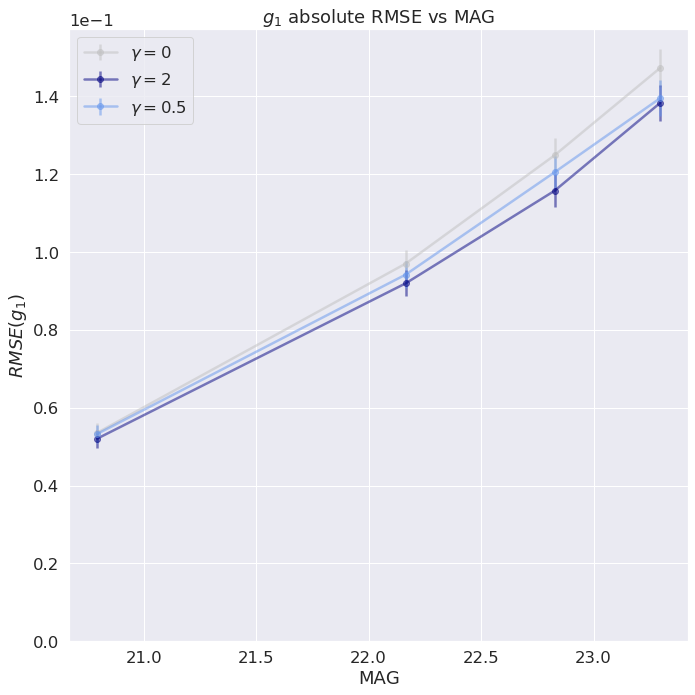

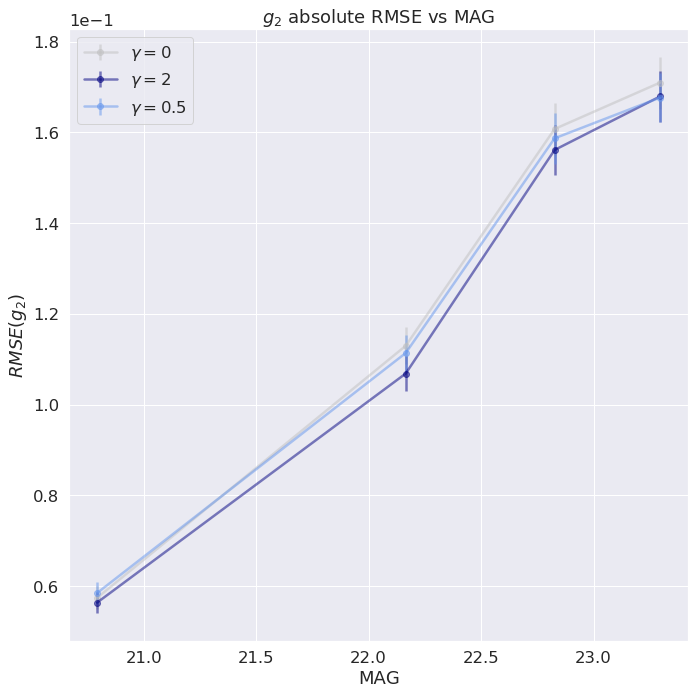

In [38]:
plt.figure(figsize=(10,10))
plt.errorbar(bins,mom_mean_g0[0],mom_std_g0[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
# plt.errorbar(bins,mom_mean_g1[0],mom_std_g1[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g1,label=label_g1,alpha=0.5)
# plt.errorbar(bins,mom_mean_g10[0],mom_std_g10[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g10,label=label_g10,alpha=0.5)
# plt.errorbar(bins,mom_mean_g01[0],mom_std_g01[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g01,label=label_g01,alpha=0.5)
plt.errorbar(bins,mom_mean_g2[0],mom_std_g2[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g2,label=label_g2,alpha=0.5)
plt.errorbar(bins,mom_mean_g05[0],mom_std_g05[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.5)
plt.ylim(bottom=0)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'MAG')
plt.ylabel(r'$RMSE(g_{1})$')
plt.title(r'$g_1$ absolute RMSE vs MAG')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
plt.errorbar(bins,mom_mean_g0[1],mom_std_g0[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
# plt.errorbar(bins,mom_mean_g1[1],mom_std_g1[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g1,label=label_g1,alpha=0.5)
# plt.errorbar(bins,mom_mean_g10[1],mom_std_g10[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g10,label=label_g10,alpha=0.5)
# plt.errorbar(bins,mom_mean_g01[1],mom_std_g01[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g01,label=label_g01,alpha=0.5)
plt.errorbar(bins,mom_mean_g2[1],mom_std_g2[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g2,label=label_g2,alpha=0.5)
plt.errorbar(bins,mom_mean_g05[1],mom_std_g05[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.5)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'MAG')
plt.ylabel(r'$RMSE(g_2)$')
plt.title(r'$g_2$ absolute RMSE vs MAG')
plt.legend()
plt.tight_layout()
plt.show()

In [39]:
mom_std_g10[0]

array([0.05571348, 0.07962337, 0.09769928, 0.10511313])

### Plot $e$ vs $\text{MAG}$

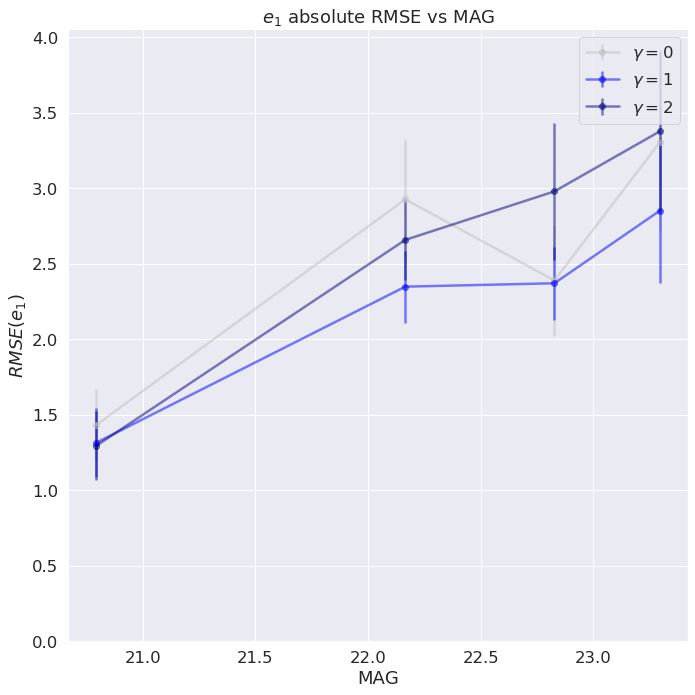

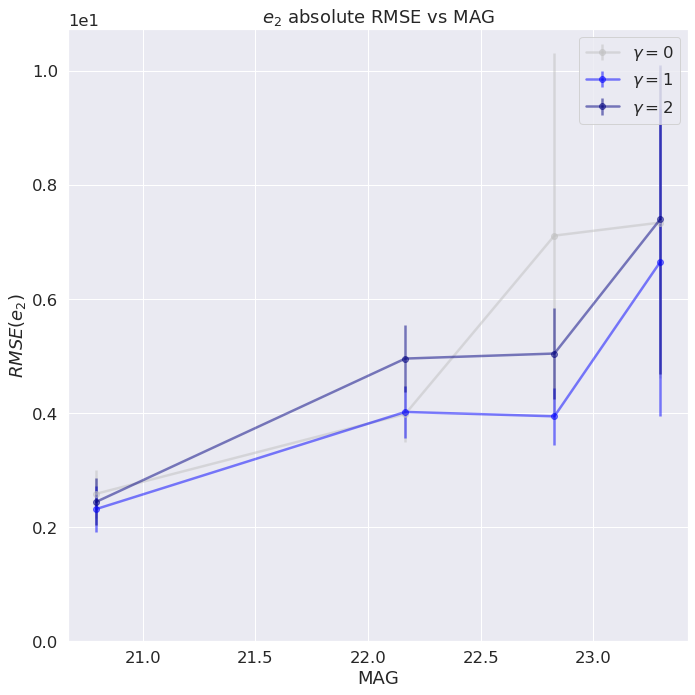

In [15]:
plt.figure(figsize=(10,10))
plt.errorbar(bins,ell_mean_g0[0],ell_std_g0[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,ell_mean_g1[0],ell_std_g1[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g1,label=label_g1,alpha=0.5)
# plt.errorbar(bins,ell_mean_g10[0],ell_std_g10[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g10,label=label_g10,alpha=0.5)
# plt.errorbar(bins,ell_mean_g01[0],ell_std_g01[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g01,label=label_g01,alpha=0.5)
plt.errorbar(bins,ell_mean_g2[0],ell_std_g2[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g2,label=label_g2,alpha=0.5)
# plt.errorbar(bins,ell_mean_g05[0],ell_std_g05[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.5)
plt.ylim(bottom=0)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
# plt.ylim([2*1e-1, 1.225])
plt.xlabel(r'MAG')
plt.ylabel(r'$RMSE(e_{1})$')
plt.title(r'$e_1$ absolute RMSE vs MAG')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
plt.errorbar(bins,ell_mean_g0[1],ell_std_g0[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,ell_mean_g1[1],ell_std_g1[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g1,label=label_g1,alpha=0.5)
# plt.errorbar(bins,ell_mean_g10[1],ell_std_g10[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g10,label=label_g10,alpha=0.5)
# plt.errorbar(bins,ell_mean_g01[1],ell_std_g01[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g01,label=label_g01,alpha=0.5)
plt.errorbar(bins,ell_mean_g2[1],ell_std_g2[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g2,label=label_g2,alpha=0.5)
# plt.errorbar(bins,ell_mean_g05[1],ell_std_g05[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.5)
plt.ylim(bottom=0)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'MAG')
plt.ylabel(r'$RMSE(e_2)$')
plt.title(r'$e_2$ absolute RMSE vs MAG')
plt.legend()
plt.tight_layout()
plt.show()

### Plot $\text{MSE}$ vs $\text{MAG}$

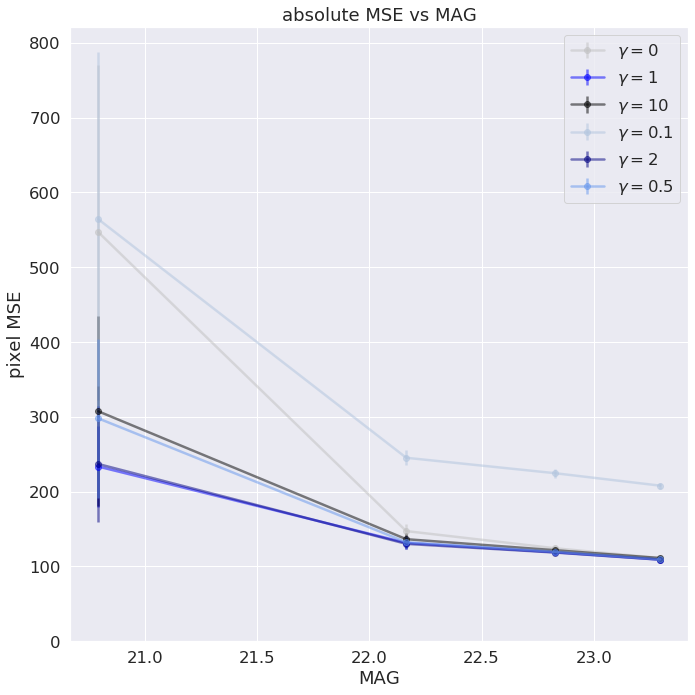

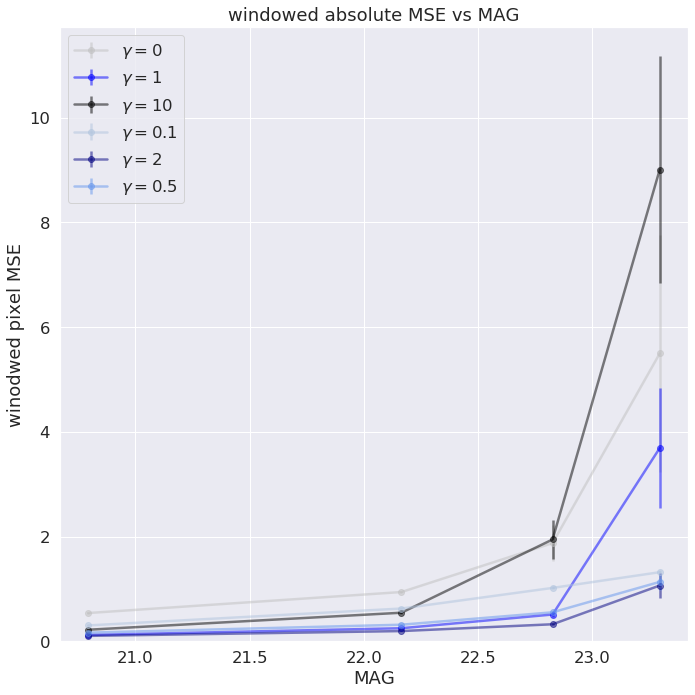

In [16]:
plt.figure(figsize=(10,10))
plt.errorbar(bins,mse_mean_g0,mse_std_g0/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,mse_mean_g1,mse_std_g1/sqrt_num_gal,linestyle='-', marker='o',color=color_g1,label=label_g1,alpha=0.5)
plt.errorbar(bins,mse_mean_g10,mse_std_g10/sqrt_num_gal,linestyle='-', marker='o',color=color_g10,label=label_g10,alpha=0.5)
plt.errorbar(bins,mse_mean_g01,mse_std_g01/sqrt_num_gal,linestyle='-', marker='o',color=color_g01,label=label_g01,alpha=0.5)
plt.errorbar(bins,mse_mean_g2,mse_std_g2/sqrt_num_gal,linestyle='-', marker='o',color=color_g2,label=label_g2,alpha=0.5)
plt.errorbar(bins,mse_mean_g05,mse_std_g05/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.5)
# plt.semilogy(bins,mse_mean_g0,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
# plt.semilogy(bins,mse_mean_g1,linestyle='-', marker='o',color=color_g1,label=label_g1,alpha=0.5)
# plt.semilogy(bins,mse_mean_g10,linestyle='-', marker='o',color=color_g1,label=label_g10,alpha=0.5)
# plt.semilogy(bins,mse_mean_g01,linestyle='-', marker='o',color=color_g1,label=label_g01,alpha=0.5)
# plt.semilogy(bins,mse_mean_g2,linestyle='-', marker='o',color=color_g1,label=label_g2,alpha=0.5)
# plt.semilogy(bins,mse_mean_g05,linestyle='-', marker='o',color=color_g1,label=label_g05,alpha=0.5)
plt.ylim(bottom=0)
#plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'MAG')
plt.ylabel(r'pixel MSE')
plt.title(r'absolute MSE vs MAG')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
plt.errorbar(bins,mse_mean_g0_w,mse_std_g0_w/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,mse_mean_g1_w,mse_std_g1_w/sqrt_num_gal,linestyle='-', marker='o',color=color_g1,label=label_g1,alpha=0.5)
plt.errorbar(bins,mse_mean_g10_w,mse_std_g10_w/sqrt_num_gal,linestyle='-', marker='o',color=color_g10,label=label_g10,alpha=0.5)
plt.errorbar(bins,mse_mean_g01_w,mse_std_g01_w/sqrt_num_gal,linestyle='-', marker='o',color=color_g01,label=label_g01,alpha=0.5)
plt.errorbar(bins,mse_mean_g2_w,mse_std_g2_w/sqrt_num_gal,linestyle='-', marker='o',color=color_g2,label=label_g2,alpha=0.5)
plt.errorbar(bins,mse_mean_g05_w,mse_std_g05_w/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.5)
# plt.semilogy(bins,mse_mean_g0_w,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
# plt.semilogy(bins,mse_mean_g1_w,linestyle='-', marker='o',color=color_g1,label=label_g1,alpha=0.5)
# plt.semilogy(bins,mse_mean_g10_w,linestyle='-', marker='o',color=color_g10,label=label_g10,alpha=0.5)
# plt.semilogy(bins,mse_mean_g01_w,linestyle='-', marker='o',color=color_g01,label=label_g01,alpha=0.5)
# plt.semilogy(bins,mse_mean_g2_w,linestyle='-', marker='o',color=color_g2,label=label_g2,alpha=0.5)
# plt.semilogy(bins,mse_mean_g05_w,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.5)
plt.ylim(bottom=0)
#plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'MAG')
plt.ylabel(r'winodwed pixel MSE')
plt.title(r'windowed absolute MSE vs MAG')
plt.legend()
plt.tight_layout()
plt.show()

### Estimate Moments and Pixel Relative Errors

In [17]:
# # compute pixel errors
# mse_g0 = np.array([MSE_obj(true,est) for true,est in zip(batch['targets'], res_np)])
# mse_g1 = np.array([MSE_obj(true,est) for true,est in zip(batch['targets'], res_g1_np)])
# mse_g10 = np.array([MSE_obj(true,est) for true,est in zip(batch['targets'], res_g10_np)])
# mse_g01 = np.array([MSE_obj(true,est) for true,est in zip(batch['targets'], res_g01_np)])
# mse_g2 = np.array([MSE_obj(true,est) for true,est in zip(batch['targets'], res_g2_np)])
# mse_g05 = np.array([MSE_obj(true,est) for true,est in zip(batch['targets'], res_g05_np)])

# compute relative pixel errors
mse_g0 = np.array([relative_mse(true,est) for true,est in zip(batch['targets'], res_np)])
mse_g1 = np.array([relative_mse(true,est) for true,est in zip(batch['targets'], res_g1_np)])
mse_g10 = np.array([relative_mse(true,est) for true,est in zip(batch['targets'], res_g10_np)])
mse_g01 = np.array([relative_mse(true,est) for true,est in zip(batch['targets'], res_g01_np)])
mse_g2 = np.array([relative_mse(true,est) for true,est in zip(batch['targets'], res_g2_np)])
mse_g05 = np.array([relative_mse(true,est) for true,est in zip(batch['targets'], res_g05_np)])

# # compute winodwed pixel errors
# mse_g0_w = np.array([MSE_obj(true*w,est*w) for true,est,w in zip(batch['targets'], res_np,windows)])
# mse_g1_w = np.array([MSE_obj(true*w,est*w) for true,est,w in zip(batch['targets'], res_g1_np,windows)])
# mse_g10_w = np.array([MSE_obj(true*w,est*w) for true,est,w in zip(batch['targets'], res_g10_np,windows)])
# mse_g01_w = np.array([MSE_obj(true*w,est*w) for true,est,w in zip(batch['targets'], res_g01_np,windows)])
# mse_g2_w = np.array([MSE_obj(true*w,est*w) for true,est,w in zip(batch['targets'], res_g2_np,windows)])
# mse_g05_w = np.array([MSE_obj(true*w,est*w) for true,est,w in zip(batch['targets'], res_g05_np,windows)])

# compute winodwed pixel relative errors
mse_g0_w = np.array([relative_mse(true*w,est*w) for true,est,w in zip(batch['targets'], res_np,windows)])
mse_g1_w = np.array([relative_mse(true*w,est*w) for true,est,w in zip(batch['targets'], res_g1_np,windows)])
mse_g10_w = np.array([relative_mse(true*w,est*w) for true,est,w in zip(batch['targets'], res_g10_np,windows)])
mse_g01_w = np.array([relative_mse(true*w,est*w) for true,est,w in zip(batch['targets'], res_g01_np,windows)])
mse_g2_w = np.array([relative_mse(true*w,est*w) for true,est,w in zip(batch['targets'], res_g2_np,windows)])
mse_g05_w = np.array([relative_mse(true*w,est*w) for true,est,w in zip(batch['targets'], res_g05_np,windows)])

# # compute adapative moments errors
# mom_err_g0 = mom_g0-mom_hst
# mom_err_g1 = mom_g1-mom_hst
# mom_err_g10 = mom_g10-mom_hst
# mom_err_g01 = mom_g01-mom_hst
# mom_err_g2 = mom_g2-mom_hst
# mom_err_g05 = mom_g05-mom_hst

# compute adapative moments relative errors
mom_err_g0 = (mom_g0-mom_hst)/mom_hst
mom_err_g1 = (mom_g1-mom_hst)/mom_hst
mom_err_g10 = (mom_g10-mom_hst)/mom_hst
mom_err_g01 = (mom_g01-mom_hst)/mom_hst
mom_err_g2 = (mom_g2-mom_hst)/mom_hst
mom_err_g05 = (mom_g05-mom_hst)/mom_hst

# #compute ellipticity errors
# ell_err_g0 = ell_g0 - ell_hst
# ell_err_g1 = ell_g1 - ell_hst
# ell_err_g10 = ell_g10 - ell_hst
# ell_err_g01 = ell_g01 - ell_hst
# ell_err_g2 = ell_g2 - ell_hst
# ell_err_g05 = ell_g05 - ell_hst

#compute ellipticity relative errors
ell_err_g0 = (ell_g0 - ell_hst)/ell_hst
ell_err_g1 = (ell_g1 - ell_hst)/ell_hst
ell_err_g10 = (ell_g10 - ell_hst)/ell_hst
ell_err_g01 = (ell_g01 - ell_hst)/ell_hst
ell_err_g2 = (ell_g2 - ell_hst)/ell_hst
ell_err_g05 = (ell_g05 - ell_hst)/ell_hst

/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in true_divide
/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher

### Compute Errors per Bin

In [18]:
label_g0 = r'$\gamma = 0$'
label_g1 = r'$\gamma = 1$'
label_g10 = r'$\gamma = 10$'
label_g01 = r'$\gamma = 0.1$'
label_g2 = r'$\gamma = 2$'
label_g05 = r'$\gamma = 0.5$'

color_g0 = 'silver'
color_g01 = 'lightsteelblue'
color_g05 = 'cornflowerblue'
color_g1 = 'blue'
color_g2 = 'navy'
color_g10 = 'black'

## Warning: Window Estimation Failures Are Filtered

As shown in the cell below, one third of the window estimation fail. As a first approach we tackle this problem by removing the failures from the analyzed data. 

In [19]:
print('Proportion of failed window estimations: {}'.format(1-window_flags.sum()/window_flags.size))

Proportion of failed window estimations: 0.34342447916666663


### Computing Errors

In [20]:
# Filter the data
original_indices = np.arange(window_flags.size)[window_flags]

# compute pixel errors
mse_g0_win = mse_g0[window_flags]
mse_g1_win = mse_g1[window_flags]
mse_g10_win = mse_g10[window_flags]
mse_g01_win = mse_g01[window_flags]
mse_g2_win = mse_g2[window_flags]
mse_g05_win = mse_g05[window_flags]

# compute winodwed relative pixel errors
mse_g0_win_w = mse_g0_w[window_flags]
mse_g1_win_w = mse_g1_w[window_flags]
mse_g10_win_w = mse_g10_w[window_flags]
mse_g01_win_w = mse_g01_w[window_flags]
mse_g2_win_w = mse_g2_w[window_flags]
mse_g05_win_w = mse_g05_w[window_flags]

# compute adapative moments errors
mom_err_g0_win = mom_err_g0[:,window_flags]
mom_err_g1_win = mom_err_g1[:,window_flags]
mom_err_g10_win = mom_err_g10[:,window_flags]
mom_err_g01_win = mom_err_g01[:,window_flags]
mom_err_g2_win = mom_err_g2[:,window_flags]
mom_err_g05_win = mom_err_g05[:,window_flags]

# compute ellipticity errors
ell_err_g0_win = ell_err_g0[:,window_flags]
ell_err_g1_win = ell_err_g1[:,window_flags]
ell_err_g10_win = ell_err_g10[:,window_flags]
ell_err_g01_win = ell_err_g01[:,window_flags]
ell_err_g2_win = ell_err_g2[:,window_flags]
ell_err_g05_win = ell_err_g05[:,window_flags]


# MAKING MAG BINS
# Binning parameters
n_bins = 4
lower_bound = np.min(batch['mag_auto'][window_flags])
mag_quantiles = []
mag_means =[]

# computing mean and standard deviation of adapative moments error per binned magnitude

mom_mean_g0 = []
mom_mean_g1 = []
mom_mean_g10 = []
mom_mean_g01 = []
mom_mean_g2 = []
mom_mean_g05 = []

mom_std_g0 = []
mom_std_g1 = []
mom_std_g10 = []
mom_std_g01 = []
mom_std_g2 = []
mom_std_g05 = []

# computing mean and standard deviation of ellipticity error per binned magnitude

ell_mean_g0 = []
ell_mean_g1 = []
ell_mean_g10 = []
ell_mean_g01 = []
ell_mean_g2 = []
ell_mean_g05 = []

ell_std_g0 = []
ell_std_g1 = []
ell_std_g10 = []
ell_std_g01 = []
ell_std_g2 = []
ell_std_g05 = []

# computing mean and standard deviation of relative mse error per binned magnitude

mse_mean_g0 = []
mse_mean_g1 = []
mse_mean_g10 = []
mse_mean_g01 = []
mse_mean_g2 = []
mse_mean_g05 = []

mse_std_g0 = []
mse_std_g1 = []
mse_std_g10 = []
mse_std_g01 = []
mse_std_g2 = []
mse_std_g05 = []

mse_mean_g0_w = []
mse_mean_g1_w = []
mse_mean_g10_w = []
mse_mean_g01_w = []
mse_mean_g2_w = []
mse_mean_g05_w = []

mse_std_g0_w = []
mse_std_g1_w = []
mse_std_g10_w = []
mse_std_g01_w = []
mse_std_g2_w = []
mse_std_g05_w = []

for i in range(n_bins-1):
    q = np.quantile(batch['mag_auto'][window_flags],(i+1)/n_bins)
    ind = np.logical_and(lower_bound<=batch['mag_auto'][window_flags],batch['mag_auto'][window_flags]<q)
    mag_quantiles += [q]
    mag_means += [np.mean(batch['mag_auto'][window_flags][ind])]
    lower_bound = q
    mom_mean_g0 += [np.mean(np.abs(mom_err_g0_win[:,ind]),axis=1)]
    mom_mean_g1 += [np.mean(np.abs(mom_err_g1_win[:,ind]),axis=1)]
    mom_mean_g10 += [np.mean(np.abs(mom_err_g10_win[:,ind]),axis=1)]
    mom_mean_g01 += [np.mean(np.abs(mom_err_g01_win[:,ind]),axis=1)]
    mom_mean_g2 += [np.mean(np.abs(mom_err_g2_win[:,ind]),axis=1)]
    mom_mean_g05 += [np.mean(np.abs(mom_err_g05_win[:,ind]),axis=1)]

    mom_std_g0 += [np.std(np.abs(mom_err_g0_win[:,ind]),axis=1)]
    mom_std_g1 += [np.std(np.abs(mom_err_g1_win[:,ind]),axis=1)]
    mom_std_g10 += [np.std(np.abs(mom_err_g10_win[:,ind]),axis=1)]
    mom_std_g01 += [np.std(np.abs(mom_err_g01_win[:,ind]),axis=1)]
    mom_std_g2 += [np.std(np.abs(mom_err_g2_win[:,ind]),axis=1)]
    mom_std_g05 += [np.std(np.abs(mom_err_g05_win[:,ind]),axis=1)]
    
    ell_mean_g0 += [np.mean(np.abs(ell_err_g0_win[:,ind]),axis=1)]
    ell_mean_g1 += [np.mean(np.abs(ell_err_g1_win[:,ind]),axis=1)]
    ell_mean_g10 += [np.mean(np.abs(ell_err_g10_win[:,ind]),axis=1)]
    ell_mean_g01 += [np.mean(np.abs(ell_err_g01_win[:,ind]),axis=1)]
    ell_mean_g2 += [np.mean(np.abs(ell_err_g2_win[:,ind]),axis=1)]
    ell_mean_g05 += [np.mean(np.abs(ell_err_g05_win[:,ind]),axis=1)]

    ell_std_g0 += [np.std(np.abs(ell_err_g0_win[:,ind]),axis=1)]
    ell_std_g1 += [np.std(np.abs(ell_err_g1_win[:,ind]),axis=1)]
    ell_std_g10 += [np.std(np.abs(ell_err_g10_win[:,ind]),axis=1)]
    ell_std_g01 += [np.std(np.abs(ell_err_g01_win[:,ind]),axis=1)]
    ell_std_g2 += [np.std(np.abs(ell_err_g2_win[:,ind]),axis=1)]
    ell_std_g05 += [np.std(np.abs(ell_err_g05_win[:,ind]),axis=1)]
    
    mse_mean_g0 += [np.mean(mse_g0_win[ind])]
    mse_mean_g1 += [np.mean(mse_g1_win[ind])]
    mse_mean_g10 += [np.mean(mse_g10_win[ind])]
    mse_mean_g01 += [np.mean(mse_g01_win[ind])]
    mse_mean_g2 += [np.mean(mse_g2_win[ind])]
    mse_mean_g05 += [np.mean(mse_g05_win[ind])]

    mse_std_g0 += [np.std(mse_g0_win[ind])]
    mse_std_g1 += [np.std(mse_g1_win[ind])]
    mse_std_g10 += [np.std(mse_g10_win[ind])]
    mse_std_g01 += [np.std(mse_g01_win[ind])]
    mse_std_g2 += [np.std(mse_g2_win[ind])]
    mse_std_g05 += [np.std(mse_g05_win[ind])]
    
    mse_mean_g0_w += [np.mean(mse_g0_win_w[ind])]
    mse_mean_g1_w += [np.mean(mse_g1_win_w[ind])]
    mse_mean_g10_w += [np.mean(mse_g10_win_w[ind])]
    mse_mean_g01_w += [np.mean(mse_g01_win_w[ind])]
    mse_mean_g2_w += [np.mean(mse_g2_win_w[ind])]
    mse_mean_g05_w += [np.mean(mse_g05_win_w[ind])]

    mse_std_g0_w += [np.std(mse_g0_win_w[ind])]
    mse_std_g1_w += [np.std(mse_g1_win_w[ind])]
    mse_std_g10_w += [np.std(mse_g10_win_w[ind])]
    mse_std_g01_w += [np.std(mse_g01_win_w[ind])]
    mse_std_g2_w += [np.std(mse_g2_win_w[ind])]
    mse_std_g05_w += [np.std(mse_g05_win_w[ind])]
    
# LAST BIN BEGIN
ind = lower_bound<=batch['mag_auto'][window_flags]
mom_mean_g0 += [np.mean(np.abs(mom_err_g0_win[:,ind]),axis=1)]
mom_mean_g1 += [np.mean(np.abs(mom_err_g1_win[:,ind]),axis=1)]
mom_mean_g10 += [np.mean(np.abs(mom_err_g10_win[:,ind]),axis=1)]
mom_mean_g01 += [np.mean(np.abs(mom_err_g01_win[:,ind]),axis=1)]
mom_mean_g2 += [np.mean(np.abs(mom_err_g2_win[:,ind]),axis=1)]
mom_mean_g05 += [np.mean(np.abs(mom_err_g05_win[:,ind]),axis=1)]

mom_std_g0 += [np.std(np.abs(mom_err_g0_win[:,ind]),axis=1)]
mom_std_g1 += [np.std(np.abs(mom_err_g1_win[:,ind]),axis=1)]
mom_std_g10 += [np.std(np.abs(mom_err_g10_win[:,ind]),axis=1)]
mom_std_g01 += [np.std(np.abs(mom_err_g01_win[:,ind]),axis=1)]
mom_std_g2 += [np.std(np.abs(mom_err_g2_win[:,ind]),axis=1)]
mom_std_g05 += [np.std(np.abs(mom_err_g05_win[:,ind]),axis=1)]

ell_mean_g0 += [np.mean(np.abs(ell_err_g0_win[:,ind]),axis=1)]
ell_mean_g1 += [np.mean(np.abs(ell_err_g1_win[:,ind]),axis=1)]
ell_mean_g10 += [np.mean(np.abs(ell_err_g10_win[:,ind]),axis=1)]
ell_mean_g01 += [np.mean(np.abs(ell_err_g01_win[:,ind]),axis=1)]
ell_mean_g2 += [np.mean(np.abs(ell_err_g2_win[:,ind]),axis=1)]
ell_mean_g05 += [np.mean(np.abs(ell_err_g05_win[:,ind]),axis=1)]

ell_std_g0 += [np.std(np.abs(ell_err_g0_win[:,ind]),axis=1)]
ell_std_g1 += [np.std(np.abs(ell_err_g1_win[:,ind]),axis=1)]
ell_std_g10 += [np.std(np.abs(ell_err_g10_win[:,ind]),axis=1)]
ell_std_g01 += [np.std(np.abs(ell_err_g01_win[:,ind]),axis=1)]
ell_std_g2 += [np.std(np.abs(ell_err_g2_win[:,ind]),axis=1)]
ell_std_g05 += [np.std(np.abs(ell_err_g05_win[:,ind]),axis=1)]

mse_mean_g0 += [np.mean(mse_g0_win[ind])]
mse_mean_g1 += [np.mean(mse_g1_win[ind])]
mse_mean_g10 += [np.mean(mse_g10_win[ind])]
mse_mean_g01 += [np.mean(mse_g01_win[ind])]
mse_mean_g2 += [np.mean(mse_g2_win[ind])]
mse_mean_g05 += [np.mean(mse_g05_win[ind])]

mse_std_g0 += [np.std(mse_g0_win[ind])]
mse_std_g1 += [np.std(mse_g1_win[ind])]
mse_std_g10 += [np.std(mse_g10_win[ind])]
mse_std_g01 += [np.std(mse_g01_win[ind])]
mse_std_g2 += [np.std(mse_g2_win[ind])]
mse_std_g05 += [np.std(mse_g05_win[ind])]

mse_mean_g0_w += [np.mean(mse_g0_win_w[ind])]
mse_mean_g1_w += [np.mean(mse_g1_win_w[ind])]
mse_mean_g10_w += [np.mean(mse_g10_win_w[ind])]
mse_mean_g01_w += [np.mean(mse_g01_win_w[ind])]
mse_mean_g2_w += [np.mean(mse_g2_win_w[ind])]
mse_mean_g05_w += [np.mean(mse_g05_win_w[ind])]

mse_std_g0_w += [np.std(mse_g0_win_w[ind])]
mse_std_g1_w += [np.std(mse_g1_win_w[ind])]
mse_std_g10_w += [np.std(mse_g10_win_w[ind])]
mse_std_g01_w += [np.std(mse_g01_win_w[ind])]
mse_std_g2_w += [np.std(mse_g2_win_w[ind])]
mse_std_g05_w += [np.std(mse_g05_win_w[ind])]

# LAST BIN END
    
# Convert to numpy array with shape (2, n_bins)

mom_mean_g0 = np.array(mom_mean_g0).T
mom_mean_g1 = np.array(mom_mean_g1).T
mom_mean_g10 = np.array(mom_mean_g10).T
mom_mean_g01 = np.array(mom_mean_g01).T
mom_mean_g2 = np.array(mom_mean_g2).T
mom_mean_g05 = np.array(mom_mean_g05).T

mom_std_g0 = np.array(mom_std_g0).T
mom_std_g1 = np.array(mom_std_g1).T
mom_std_g10 = np.array(mom_std_g10).T
mom_std_g01 = np.array(mom_std_g01).T
mom_std_g2 = np.array(mom_std_g2).T
mom_std_g05 = np.array(mom_std_g05).T

ell_mean_g0 = np.array(ell_mean_g0).T
ell_mean_g1 = np.array(ell_mean_g1).T
ell_mean_g10 = np.array(ell_mean_g10).T
ell_mean_g01 = np.array(ell_mean_g01).T
ell_mean_g2 = np.array(ell_mean_g2).T
ell_mean_g05 = np.array(ell_mean_g05).T

ell_std_g0 = np.array(ell_std_g0).T
ell_std_g1 = np.array(ell_std_g1).T
ell_std_g10 = np.array(ell_std_g10).T
ell_std_g01 = np.array(ell_std_g01).T
ell_std_g2 = np.array(ell_std_g2).T
ell_std_g05 = np.array(ell_std_g05).T

mse_mean_g0 = np.array(mse_mean_g0).T
mse_mean_g1 = np.array(mse_mean_g1).T
mse_mean_g10 = np.array(mse_mean_g10).T
mse_mean_g01 = np.array(mse_mean_g01).T
mse_mean_g2 = np.array(mse_mean_g2).T
mse_mean_g05 = np.array(mse_mean_g05).T

mse_std_g0 = np.array(mse_std_g0).T
mse_std_g1 = np.array(mse_std_g1).T
mse_std_g10 = np.array(mse_std_g10).T
mse_std_g01 = np.array(mse_std_g01).T
mse_std_g2 = np.array(mse_std_g2).T
mse_std_g05 = np.array(mse_std_g05).T

mse_mean_g0_w = np.array(mse_mean_g0_w).T
mse_mean_g1_w = np.array(mse_mean_g1_w).T
mse_mean_g10_w = np.array(mse_mean_g10_w).T
mse_mean_g01_w = np.array(mse_mean_g01_w).T
mse_mean_g2_w = np.array(mse_mean_g2_w).T
mse_mean_g05_w = np.array(mse_mean_g05_w).T

mse_std_g0_w = np.array(mse_std_g0_w).T
mse_std_g1_w = np.array(mse_std_g1_w).T
mse_std_g10_w = np.array(mse_std_g10_w).T
mse_std_g01_w = np.array(mse_std_g01_w).T
mse_std_g2_w = np.array(mse_std_g2_w).T
mse_std_g05_w = np.array(mse_std_g05_w).T

In [21]:
# BEGIN BINNING
# Partition galaxies into bins of equal size
# Initialize lower bound
lower_bound = np.min(batch['mag_auto'][window_flags])
gal_sum = 0
bins = []

sqrt_num_gal = [] # conversion factor of standard deviation to mean error standard deviation

for i in range(n_bins-1):
    # compute quantile that is used as an upper bound
    q = np.quantile(batch['mag_auto'][window_flags],(i+1)/n_bins)
    # retrieve galaxy indices which magnitude are between the bounds
    cond = np.logical_and(lower_bound<=batch['mag_auto'][window_flags],batch['mag_auto'][window_flags]<q)
    # retrieve corresponding objects
    mag_q = batch['mag_auto'][window_flags][cond]
    print(i+1, q, np.mean(mag_q))
    bins += [np.mean(mag_q)]
    # compute the square root of the bin size
    sqrt_num_gal += [np.sqrt(np.sum(cond))]
    # update lower bound
    lower_bound = q
# retrieve last bin indices
cond = lower_bound<=batch['mag_auto'][window_flags]
# retrieve corresponding objects
mag_q = batch['mag_auto'][window_flags][cond]
bins += [np.mean(mag_q)]
# compute the square root of the bin size
sqrt_num_gal += [np.sqrt(np.sum(cond))]
print(i+1, q, np.mean(mag_q))

# END BINNING


1 21.718219757080078 20.793262
2 22.555931091308594 22.164833
3 23.062789916992188 22.826544
3 23.062789916992188 23.29574


### Plot $g$ vs $\text{MAG}$

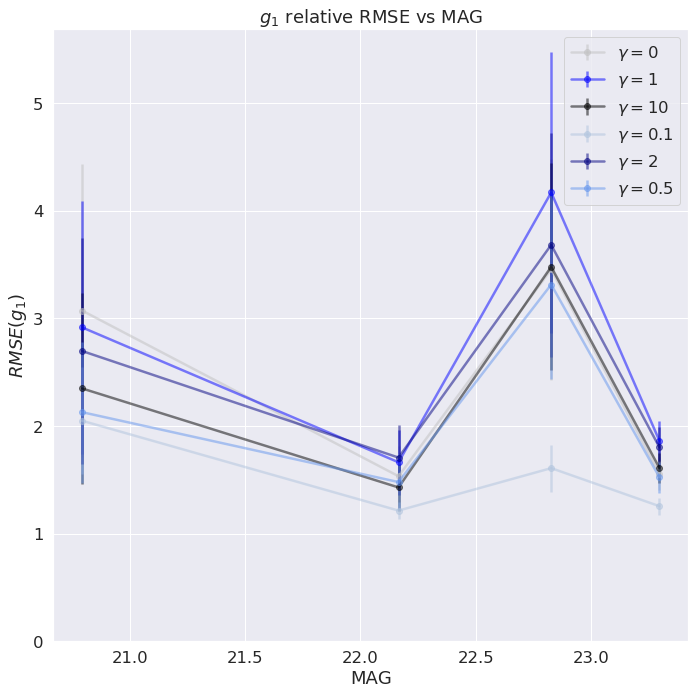

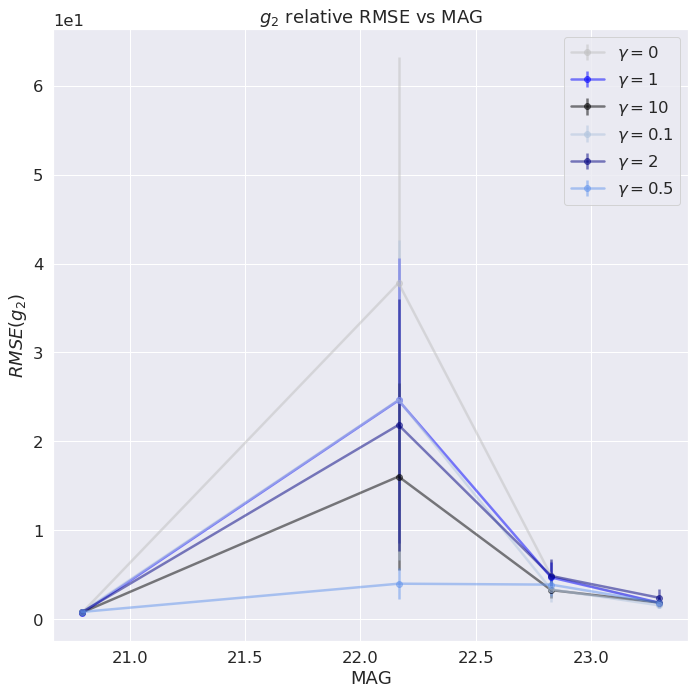

In [22]:
plt.figure(figsize=(10,10))
plt.errorbar(bins,mom_mean_g0[0],mom_std_g0[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,mom_mean_g1[0],mom_std_g1[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g1,label=label_g1,alpha=0.5)
plt.errorbar(bins,mom_mean_g10[0],mom_std_g10[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g10,label=label_g10,alpha=0.5)
plt.errorbar(bins,mom_mean_g01[0],mom_std_g01[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g01,label=label_g01,alpha=0.5)
plt.errorbar(bins,mom_mean_g2[0],mom_std_g2[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g2,label=label_g2,alpha=0.5)
plt.errorbar(bins,mom_mean_g05[0],mom_std_g05[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.5)
plt.ylim(bottom=0)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'MAG')
plt.ylabel(r'$RMSE(g_{1})$')
plt.title(r'$g_1$ relative RMSE vs MAG')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
plt.errorbar(bins,mom_mean_g0[1],mom_std_g0[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,mom_mean_g1[1],mom_std_g1[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g1,label=label_g1,alpha=0.5)
plt.errorbar(bins,mom_mean_g10[1],mom_std_g10[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g10,label=label_g10,alpha=0.5)
plt.errorbar(bins,mom_mean_g01[1],mom_std_g01[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g01,label=label_g01,alpha=0.5)
plt.errorbar(bins,mom_mean_g2[1],mom_std_g2[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g2,label=label_g2,alpha=0.5)
plt.errorbar(bins,mom_mean_g05[1],mom_std_g05[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.5)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'MAG')
plt.ylabel(r'$RMSE(g_2)$')
plt.title(r'$g_2$ relative RMSE vs MAG')
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
mom_std_g10[0]

array([19.89326688,  4.96463102, 21.56482196,  3.19639205])

### Plot $e$ vs $\text{MAG}$

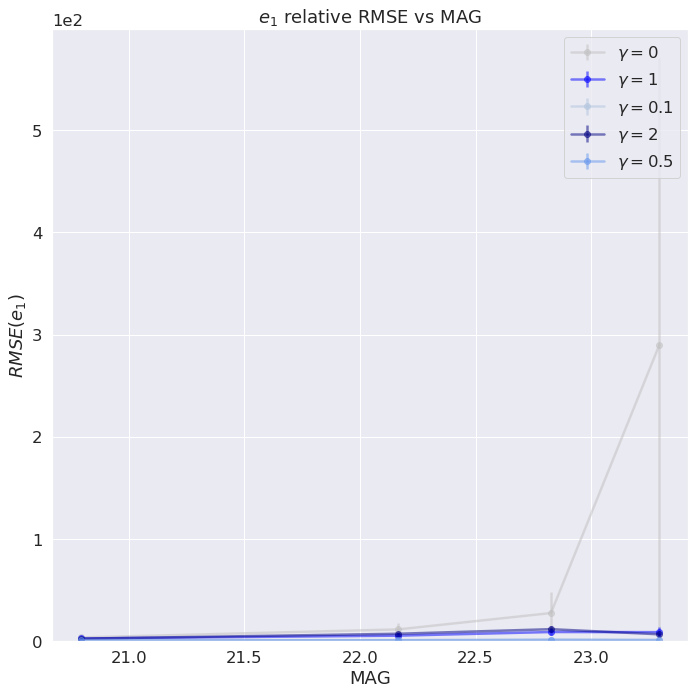

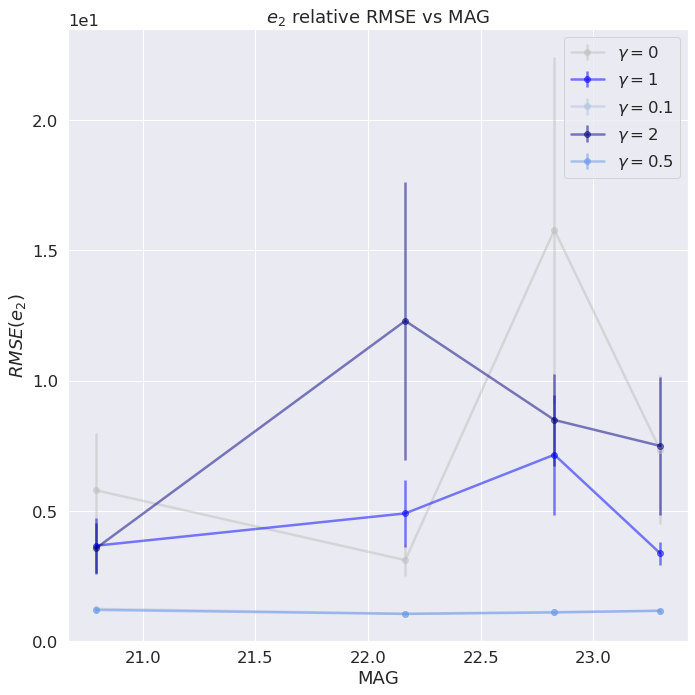

In [24]:
plt.figure(figsize=(10,10))
plt.errorbar(bins,ell_mean_g0[0],ell_std_g0[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,ell_mean_g1[0],ell_std_g1[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g1,label=label_g1,alpha=0.5)
# plt.errorbar(bins,ell_mean_g10[0],ell_std_g10[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g10,label=label_g10,alpha=0.5)
plt.errorbar(bins,ell_mean_g01[0],ell_std_g01[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g01,label=label_g01,alpha=0.5)
plt.errorbar(bins,ell_mean_g2[0],ell_std_g2[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g2,label=label_g2,alpha=0.5)
plt.errorbar(bins,ell_mean_g05[0],ell_std_g05[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.5)
plt.ylim(bottom=0)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
# plt.ylim([2*1e-1, 1.225])
plt.xlabel(r'MAG')
plt.ylabel(r'$RMSE(e_{1})$')
plt.title(r'$e_1$ relative RMSE vs MAG')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
plt.errorbar(bins,ell_mean_g0[1],ell_std_g0[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,ell_mean_g1[1],ell_std_g1[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g1,label=label_g1,alpha=0.5)
# plt.errorbar(bins,ell_mean_g10[1],ell_std_g10[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g10,label=label_g10,alpha=0.5)
plt.errorbar(bins,ell_mean_g01[1],ell_std_g01[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g01,label=label_g01,alpha=0.5)
plt.errorbar(bins,ell_mean_g2[1],ell_std_g2[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g2,label=label_g2,alpha=0.5)
plt.errorbar(bins,ell_mean_g05[1],ell_std_g05[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.5)
plt.ylim(bottom=0)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'MAG')
plt.ylabel(r'$RMSE(e_2)$')
plt.title(r'$e_2$ relative RMSE vs MAG')
plt.legend()
plt.tight_layout()
plt.show()

### Plot $\text{MSE}$ vs $\text{MAG}$

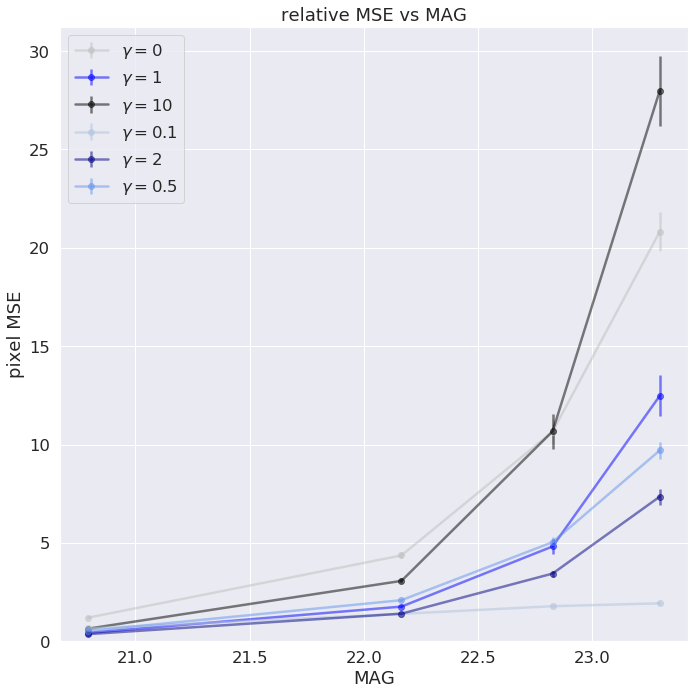

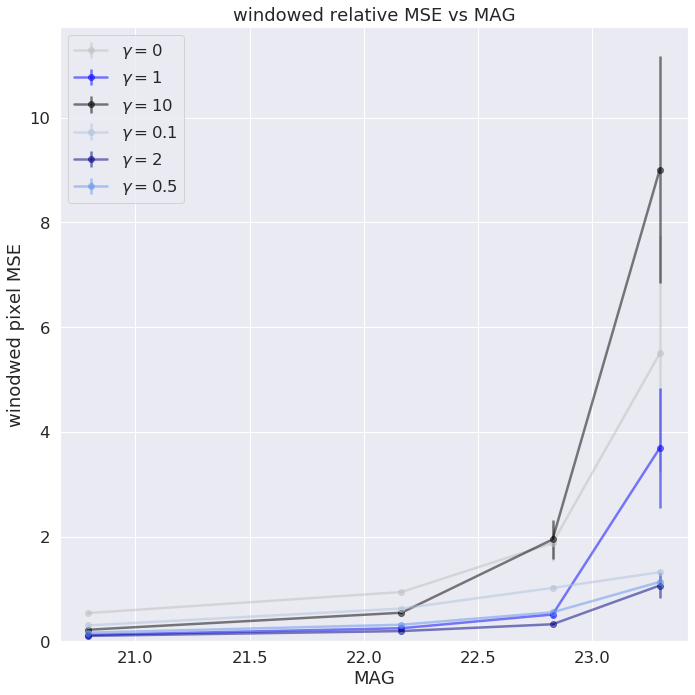

In [25]:
plt.figure(figsize=(10,10))
plt.errorbar(bins,mse_mean_g0,mse_std_g0/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,mse_mean_g1,mse_std_g1/sqrt_num_gal,linestyle='-', marker='o',color=color_g1,label=label_g1,alpha=0.5)
plt.errorbar(bins,mse_mean_g10,mse_std_g10/sqrt_num_gal,linestyle='-', marker='o',color=color_g10,label=label_g10,alpha=0.5)
plt.errorbar(bins,mse_mean_g01,mse_std_g01/sqrt_num_gal,linestyle='-', marker='o',color=color_g01,label=label_g01,alpha=0.5)
plt.errorbar(bins,mse_mean_g2,mse_std_g2/sqrt_num_gal,linestyle='-', marker='o',color=color_g2,label=label_g2,alpha=0.5)
plt.errorbar(bins,mse_mean_g05,mse_std_g05/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.5)
# plt.semilogy(bins,mse_mean_g0,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
# plt.semilogy(bins,mse_mean_g1,linestyle='-', marker='o',color=color_g1,label=label_g1,alpha=0.5)
# plt.semilogy(bins,mse_mean_g10,linestyle='-', marker='o',color=color_g1,label=label_g10,alpha=0.5)
# plt.semilogy(bins,mse_mean_g01,linestyle='-', marker='o',color=color_g1,label=label_g01,alpha=0.5)
# plt.semilogy(bins,mse_mean_g2,linestyle='-', marker='o',color=color_g1,label=label_g2,alpha=0.5)
# plt.semilogy(bins,mse_mean_g05,linestyle='-', marker='o',color=color_g1,label=label_g05,alpha=0.5)
plt.ylim(bottom=0)
#plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'MAG')
plt.ylabel(r'pixel MSE')
plt.title(r'relative MSE vs MAG')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
plt.errorbar(bins,mse_mean_g0_w,mse_std_g0_w/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,mse_mean_g1_w,mse_std_g1_w/sqrt_num_gal,linestyle='-', marker='o',color=color_g1,label=label_g1,alpha=0.5)
plt.errorbar(bins,mse_mean_g10_w,mse_std_g10_w/sqrt_num_gal,linestyle='-', marker='o',color=color_g10,label=label_g10,alpha=0.5)
plt.errorbar(bins,mse_mean_g01_w,mse_std_g01_w/sqrt_num_gal,linestyle='-', marker='o',color=color_g01,label=label_g01,alpha=0.5)
plt.errorbar(bins,mse_mean_g2_w,mse_std_g2_w/sqrt_num_gal,linestyle='-', marker='o',color=color_g2,label=label_g2,alpha=0.5)
plt.errorbar(bins,mse_mean_g05_w,mse_std_g05_w/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.5)
# plt.semilogy(bins,mse_mean_g0_w,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
# plt.semilogy(bins,mse_mean_g1_w,linestyle='-', marker='o',color=color_g1,label=label_g1,alpha=0.5)
# plt.semilogy(bins,mse_mean_g10_w,linestyle='-', marker='o',color=color_g10,label=label_g10,alpha=0.5)
# plt.semilogy(bins,mse_mean_g01_w,linestyle='-', marker='o',color=color_g01,label=label_g01,alpha=0.5)
# plt.semilogy(bins,mse_mean_g2_w,linestyle='-', marker='o',color=color_g2,label=label_g2,alpha=0.5)
# plt.semilogy(bins,mse_mean_g05_w,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.5)
plt.ylim(bottom=0)
#plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'MAG')
plt.ylabel(r'winodwed pixel MSE')
plt.title(r'windowed relative MSE vs MAG')
plt.legend()
plt.tight_layout()
plt.show()